In [2]:
library('BoolNet')
library('dplyr')
library('alluvial')
library("stringr")
library('pheatmap')
library('data.table')
for (f in list.files("BNP")) { source( paste('BNP/', f, sep='') ) }
simplifyLabel <- function(old, sep='/', mark='*', replace=NULL) { 
        new <- str_split(old,sep)
        new <- sort(unique(new[[1]]))
        new <- paste(new, collapse=sep)
        if (! is.null(replace)) {
          for (key in names(replace)) {
            new <- str_replace( new, pattern=key, replace[[key]] )
          }
        }
        if (! is.null(mark)) { 
          if (new!=old) {
            new <- paste(c(new,mark), collapse='')
          }
        }
        new
      }
plot.heatmap <- function(attr.table, title, gaps){
      pheatmap(t(as.matrix( subset(attr.table, select=-c(label,state) ))),
               labels_col = attr.table[,"label"],
               main= title,
               color=c('#fb8072','#b3de69'),
               cluster_cols = F, cluster_rows = F,
               gaps_col = gaps, scale = "none"
      )
}
replace.labels <- list('bM1M2'='M1M2', 'M1/M1M2/NoLabel'='M1M2/NoLabel', 'il6/M0/M2/M2c'='M2c', 'il6/M0/M2/M2b'='M2b', 
                       'il6/M0/M1/M2b'='M2b', 'M1M2/NoLabel'='M1M2/NoLabel', 'M1M2/M1/M1M2'='M1M2', 'il6/M0/M1/M2'='M1M2', 
                       'M1M2/M2/M2d'='M1M2', 'il6/M2b/M2c'='M2', 'M1/NoLabel'='M1/NoLabel', 'M0/M2b/M2c'='M2', 
                       'il6/M2/M2c'='M2c', 'il6/M2/M2b'='M2b', 'il6/M1/M2b'='M1M2', 'il6/M0/M2b'='M2b', 'M1/M2/M2c'='M2c', 
                       'M1/M2/M2b'='M2b', 'M0/M2/M2c'='M2c', 'M0/M2/M2b'='M2b', 'M0/M1/M2b'='M1M2', 'il6/M1/M2'='M1M2', 
                       'il6/M0/M2'='M2', 'il6/M0/M1'='M1', 'M1M2/M2d'='M1M2', 'M0/M1/M2'='M1M2', 'M2b/M2c'='M2', 
                       'M1M2/M2'='M1M2', 'M1M2/M1'='M1M2', 'M1/M1M2'='M1M2', 'il6/M2b'='M2b', 'M2/M2d'='M2d', 'M2/M2a'='M2a', 
                       'M1/M2b'='M1M2', 'M0/M2b'='M2b', 'il6/M2'='M2', 'il6/M1'='M1', 'il6/M0'='il6', 'M1/M2'='M1M2', 
                       'M0/M2'='M2', 'M0/M1'='M1')
# Load data
net <- loadNetwork(file = "CSV/MP_reduced_network.csv")
lab <- read.csv("CSV/MP_label_rules.csv")

## Full Regulatory Network

![title](MODEL/MP_full_network.png)

## Reduced Regulatory Network

![title](MODEL/MP_reduced_network.png)

## Attractors

In [3]:
get.basin <- F
if(get.basin){
    attr <- getAttractors(net, method="exhaustive")
    saveRDS(attr, file = "CSV/MP_attractors_basin.rds")
    basin.table <- attractorToDataframe(attr)
    write.csv(x = basin.table, file = "CSV/MP_basin.csv", row.names = F)
    }

In [4]:
file.attr <- "CSV/MP_reduced_attractors.csv"
file.label <- "CSV/MP_attr_label_wt.csv"
if (! file.exists(file.attr)) {
    attr <- getAttractors(net, method="sat.exhaustive")
    saveRDS(attr, file = "CSV/MP_attractors.rds")
    attr.table <- attractorToDataframe(attr, Boolean=TRUE)

    l_long <- labelAttractors(attr, lab, net$genes)
    labels <- data.frame(attractor=NA, label=NA)[numeric(0), ]
    for (a in 1:length(l_long)) {
          l <- simplifyLabel(l_long[[a]], replace=replace.labels)
          labels[nrow(labels) + 1,] = c(a,l)
    }

    state.label <- data.frame(state=integer(), attractor=integer())
    for (n in 1:length(attr$attractors)) {
          states <- attr$attractors[[n]]$involvedStates
          for (s in states) {
                state.label[nrow(state.label) + 1,] = c(s,n)
          }
    }
    state.label <- merge(x=state.label, y=labels, by="attractor", all = TRUE)
    attr.table <- merge(x = labels, y = attr.table, by = "attractor", all = TRUE)
    # Sorting attractor table by estimulus
    est.ind <- (which(str_detect(colnames(attr.table), "_e") == T))
    attr.table <- attr.table[,c(1:3,est.ind ,(4:ncol(attr.table))[-(est.ind-3)])]
    attr.table <- attr.table[order(attr.table$label),]
    write.csv(attr.table, file.attr, row.names=FALSE)
    write.csv(state.label, file.label, row.names=FALSE)
} else {
    attr.table <- read.csv(file = file.attr)
    labels <- read.csv(file = file.label)  
}
attr.table[1000:1005,]

,attractor,label,state,IFNG_e,GMCSF_e,IL1B_e,IC_e,LPS_e,NECA_e,EGFR_e,...,KLF4,STAT6,IL10_out,SOCS1,PPARG,STAT3_IL6,STAT3_IL10,SOCS3,IL6R,IL10R
1000,2343,il6*,4,0,0,0,1,0,1,1,...,0,0,0,0,0,1,0,1,1,0
1001,2343,il6*,5,0,0,0,1,0,1,1,...,0,0,0,0,0,1,0,1,0,0
1002,2343,il6*,6,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,1,0,0
1003,2344,il6*,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1004,2344,il6*,2,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1005,2344,il6*,3,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,1,0


In [5]:
# Finding the index of the end of each state
attr.table <- subset(attr.table, select = c("label", "state","STAT1", "STAT5", "NFKB", "STAT6",
                                            "STAT3_IL10", "STAT3_IL6", "IL12_out", "IL10_out", "IL6_out", "VEGF_out") )
cycle.index <- data.frame()

for (i in 1:(nrow(attr.table)-1)) {
      if(attr.table$state[i] >= attr.table$state[i + 1]){
            cycle.index <- rbind(cycle.index,
                                 cbind(cycle.n = attr.table$state[i],
                                               index = i))
      }  
}
# cycle.index contains the indices of the last attractor of all states
cycle.index <- rbind(cycle.index, cbind(cycle.n = attr.table$state[i + 1],
                                        index = i + 1))
# Finding the unique cyclic states
cycle.sizes <- sort(unique(cycle.index$cycle.n))
attr.cycles.list <- list()
for (size in cycle.sizes) {
      size.indexes <- which(cycle.index$cycle.n == size)
      size.indexes <- cycle.index$index[size.indexes]
      if(size > 1){
            table.unique <- attr.table[size.indexes - (size-1),]
            for (i in (size-2):0) table.unique <- cbind(table.unique, attr.table[size.indexes - i,])
            table.unique <- unique(table.unique)
            col.factor <- (ncol(table.unique)/size)
            table <- table.unique[,1:col.factor]
            for (i in seq(col.factor + 1,ncol(table.unique),ncol(table.unique) / size)) {
                  table <- rbind(table,
                                 table.unique[,i:(i+(col.factor-1))])
            }
            indexing.ord <- c()
            for (i in 1:(nrow(table)/size)) indexing.ord <- c(indexing.ord, seq(i, nrow(table), nrow(table)/size))
            table <- table[indexing.ord,]
      } else { table <- unique(attr.table[size.indexes,])}
      attr.cycles.list[[size]] <- table
}

rm(size.indexes, size, cycle.index, i, table.unique, indexing.ord, table)

[1] 1
[1] 2


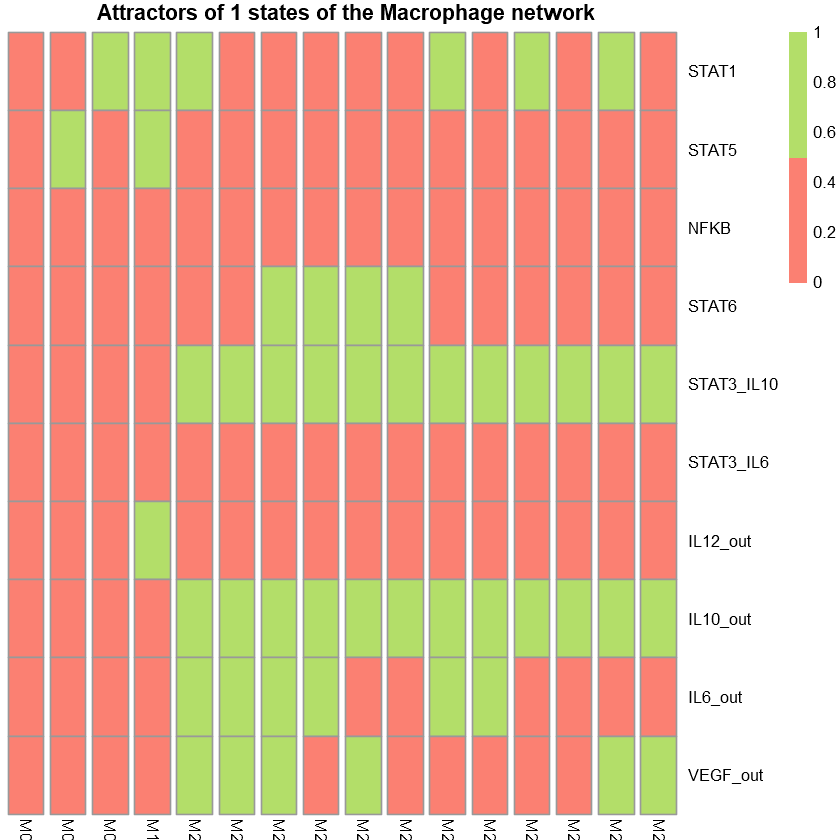

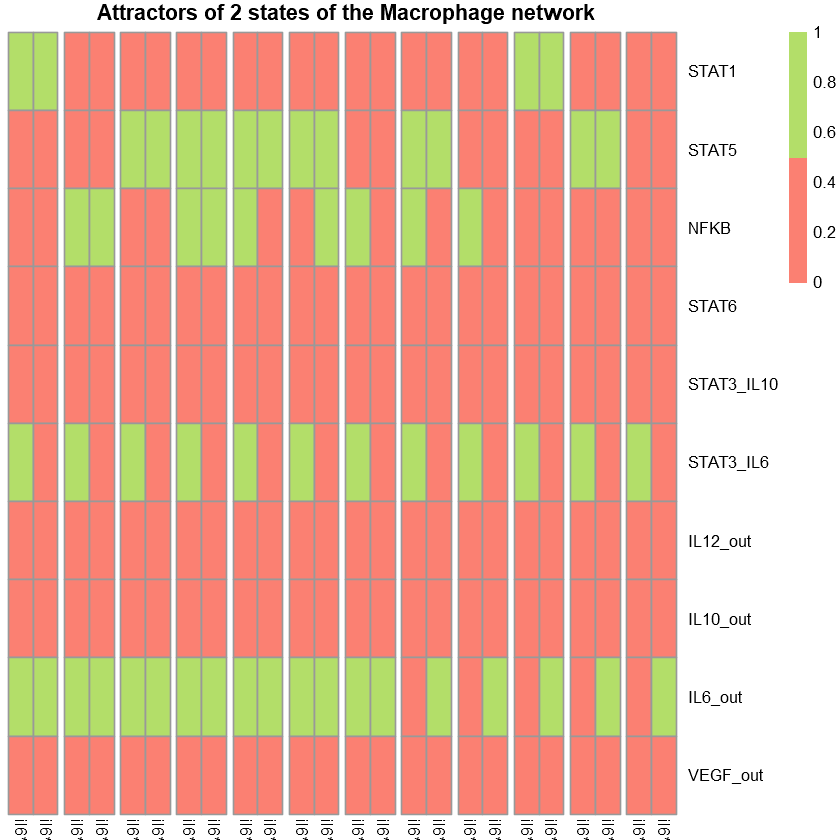

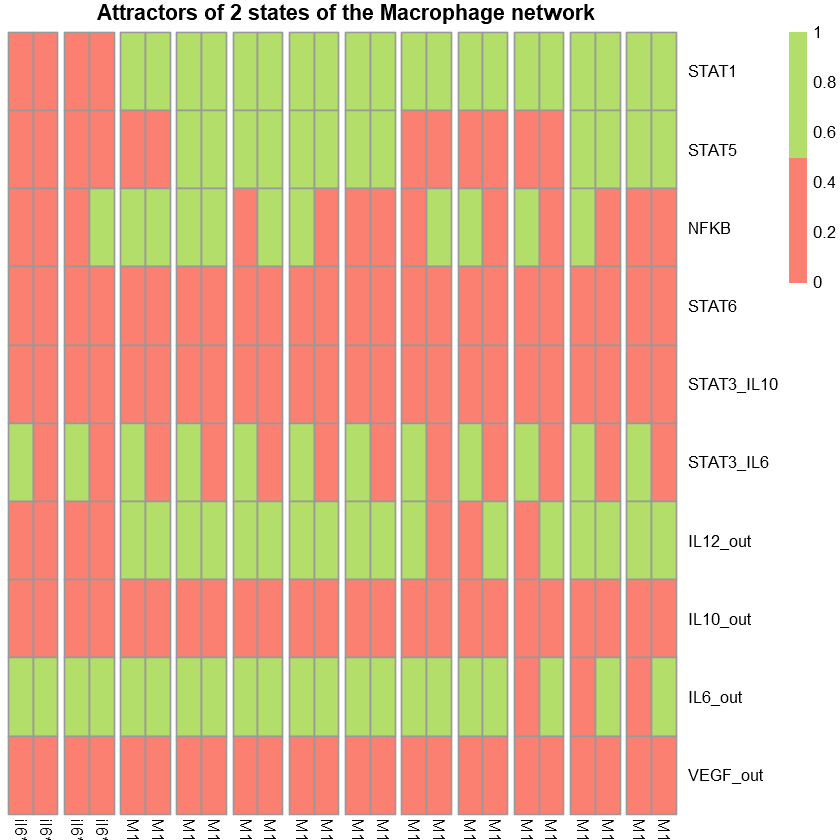

[1] 3


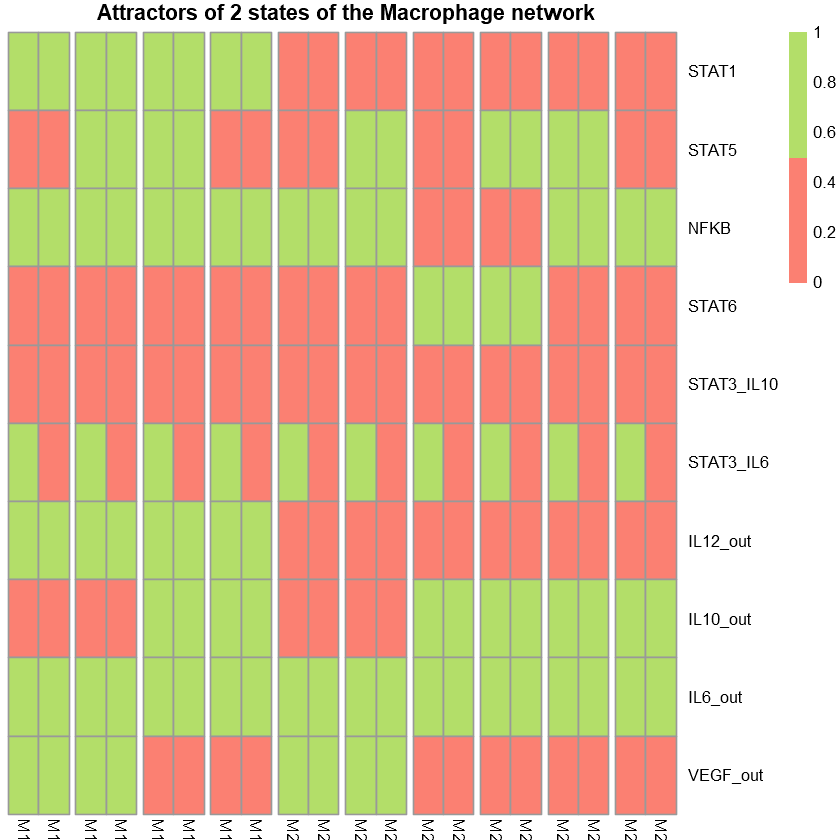

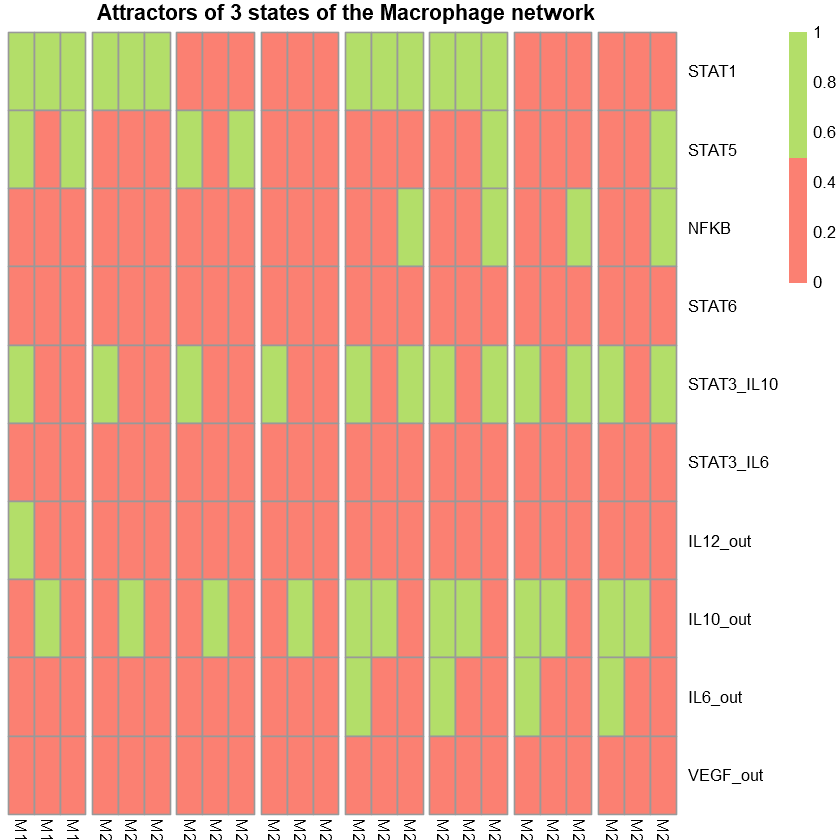

[1] 6


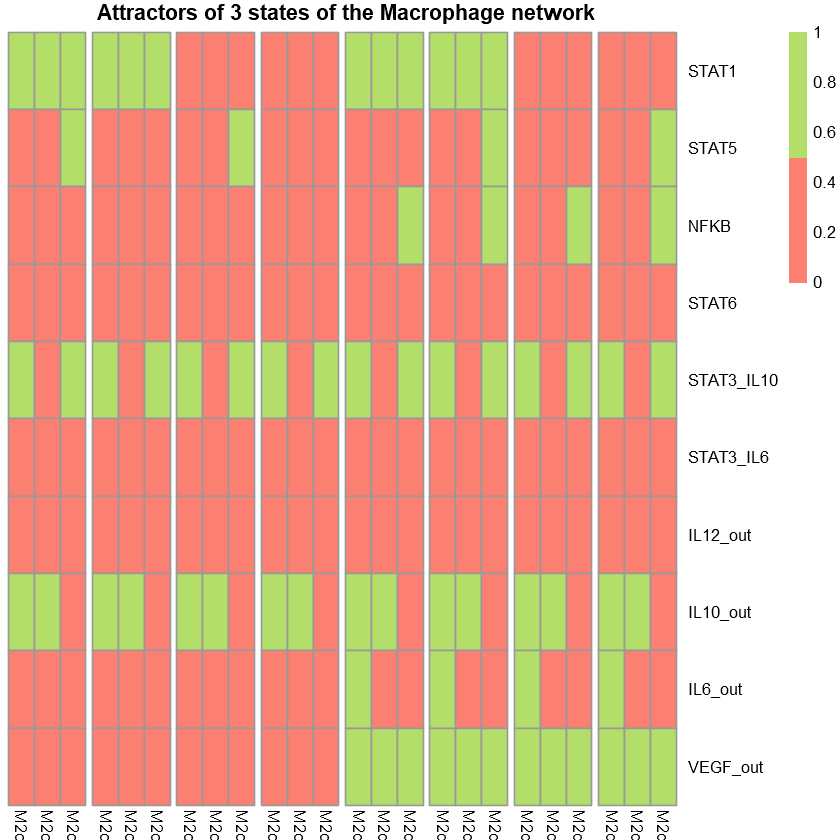

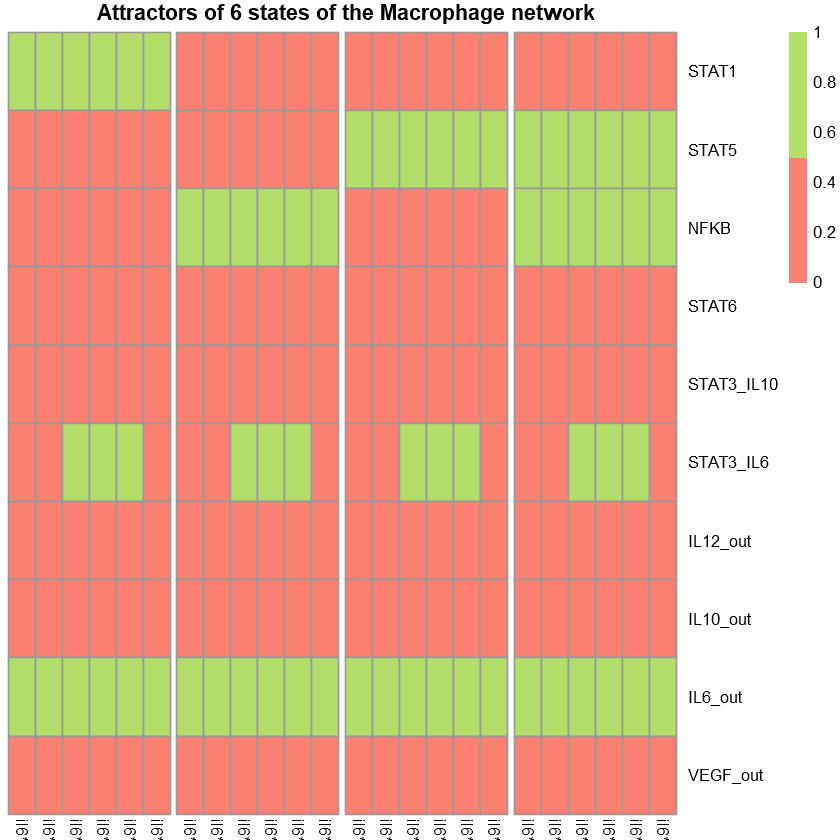

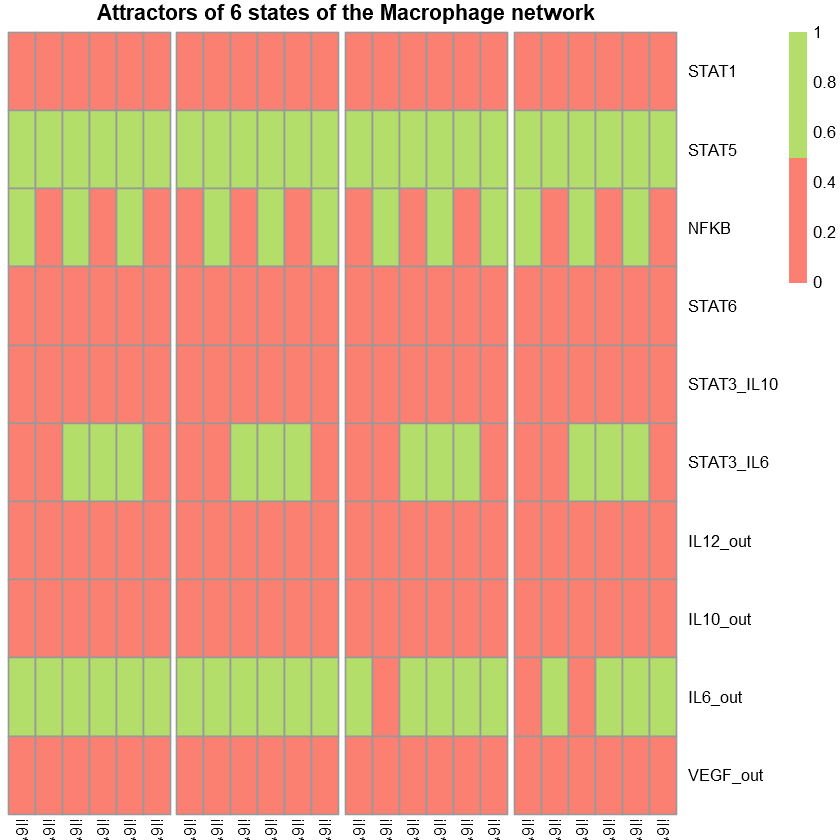

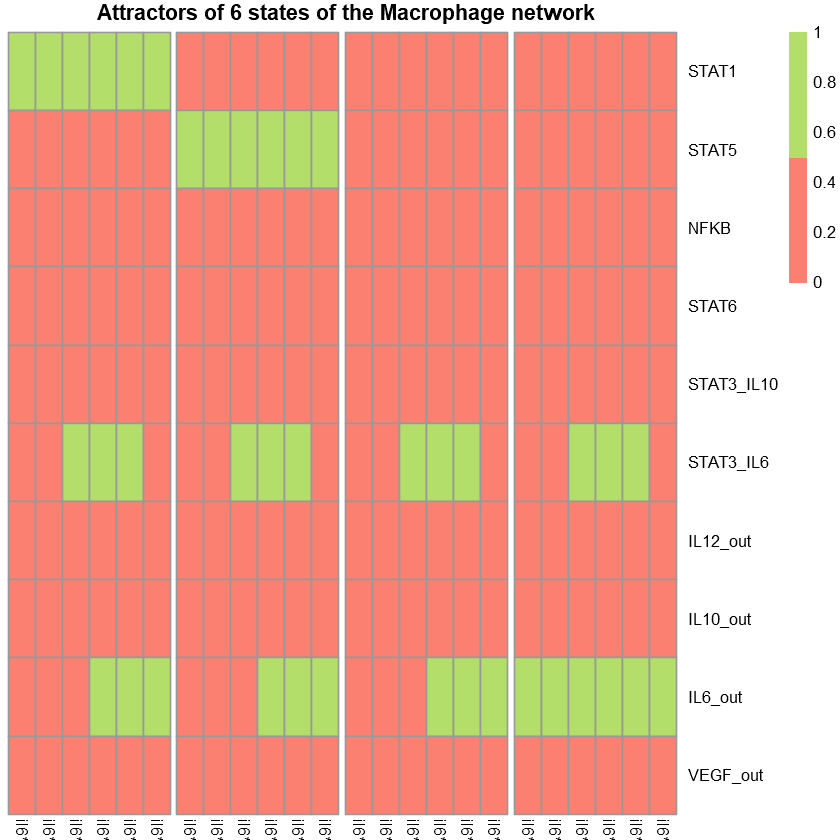

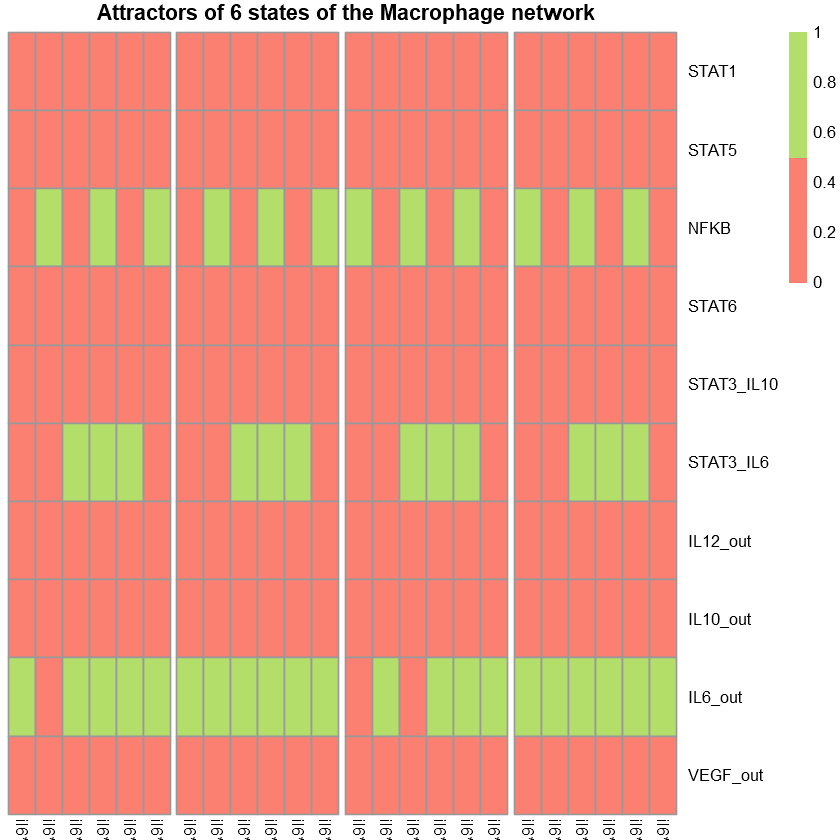

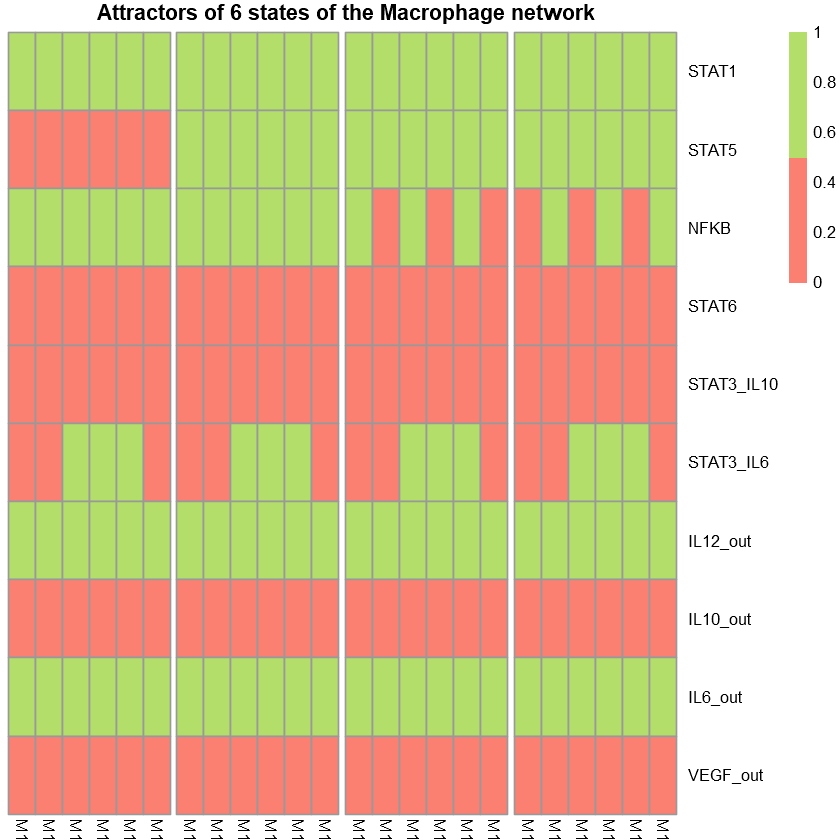

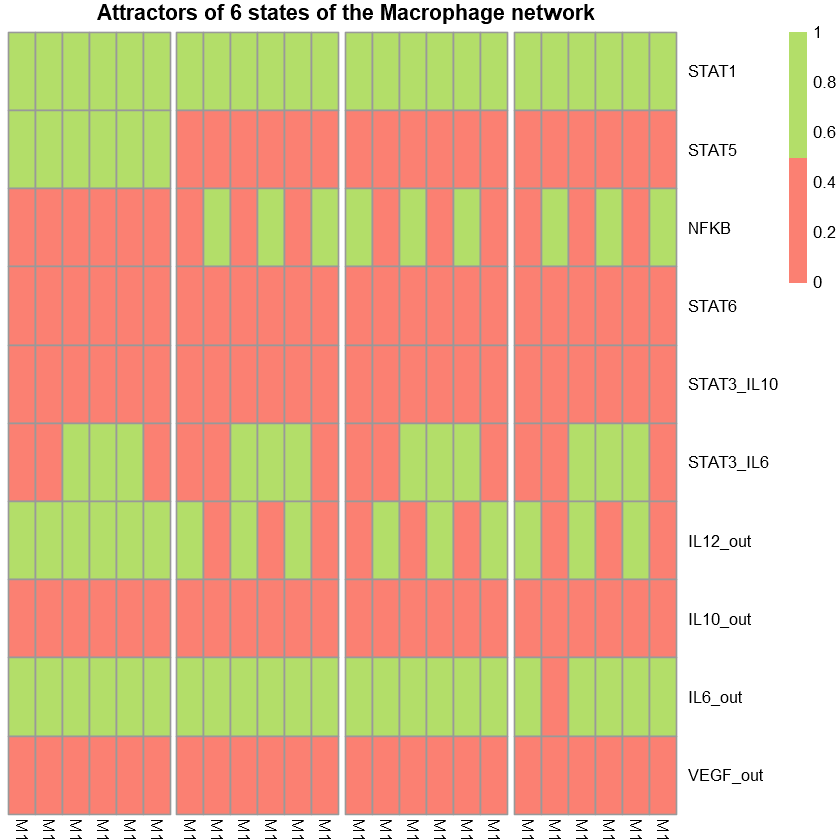

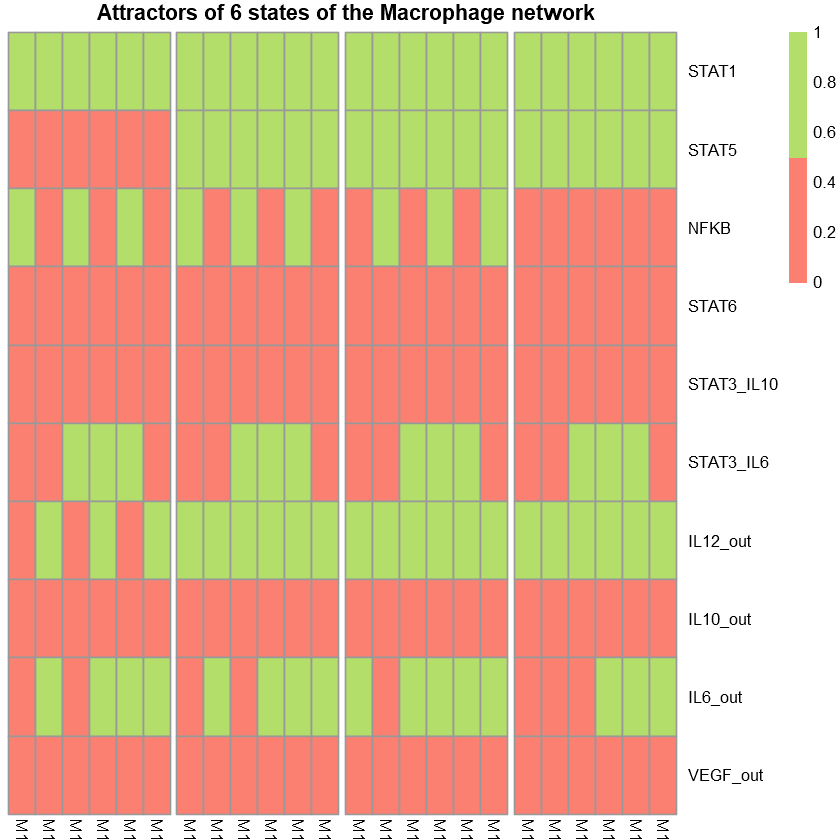

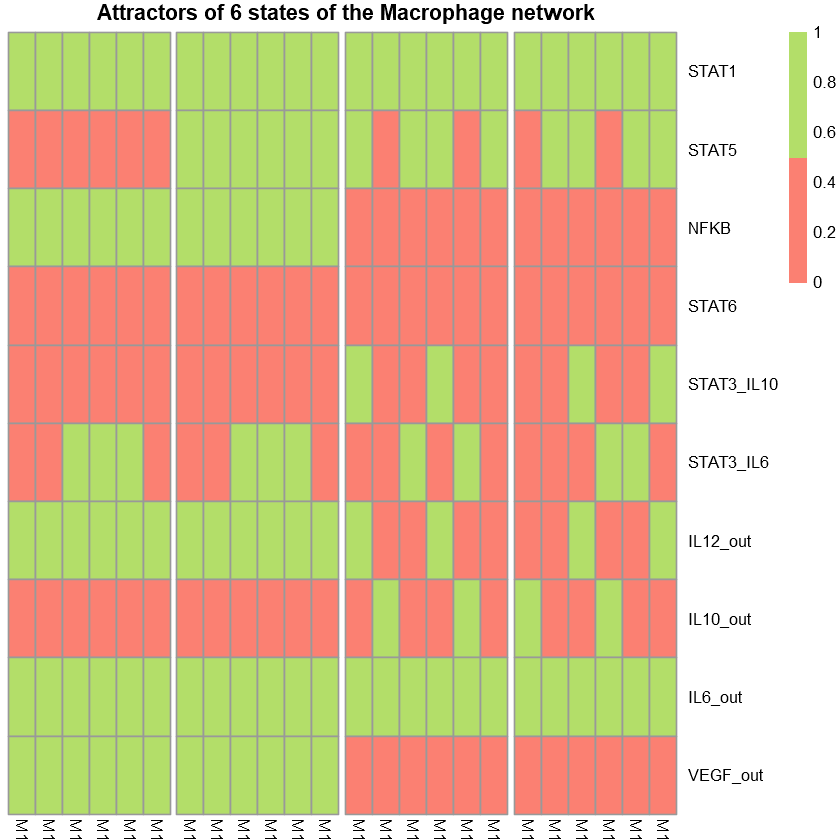

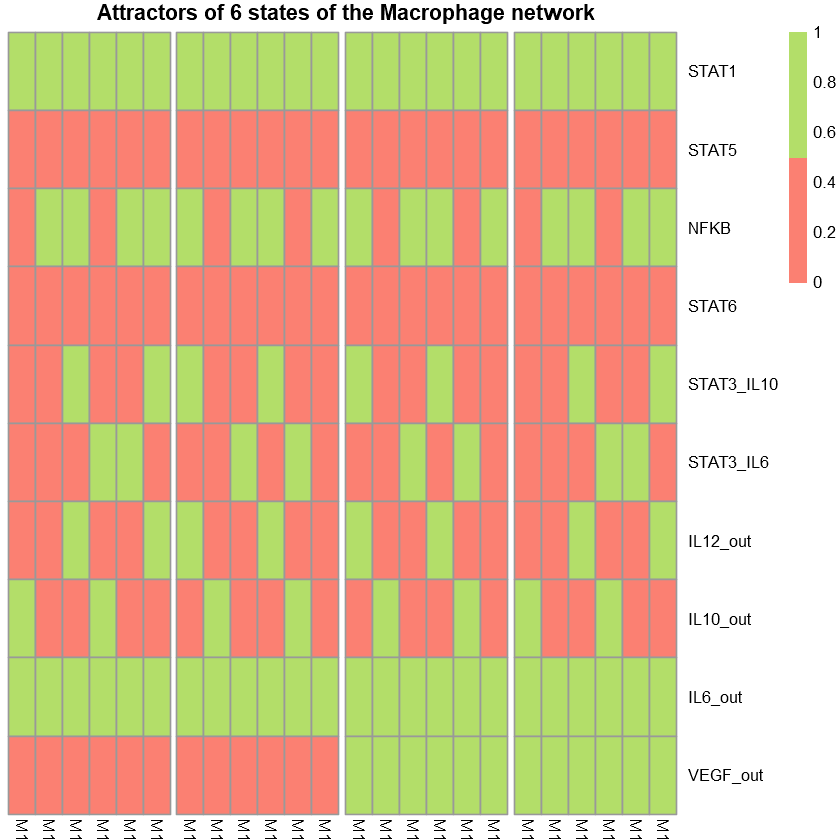

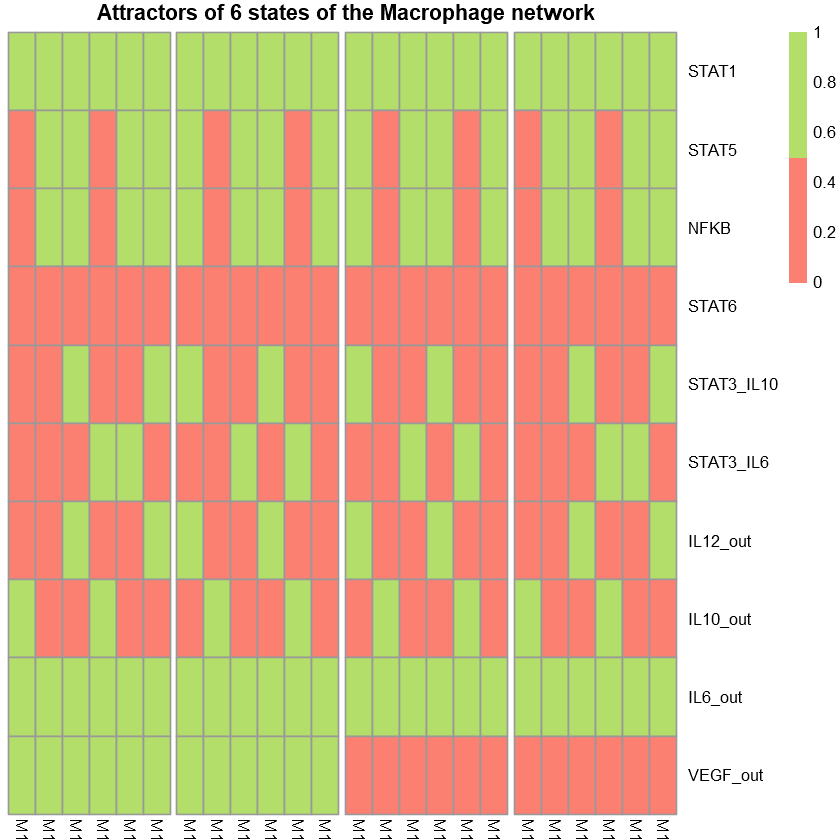

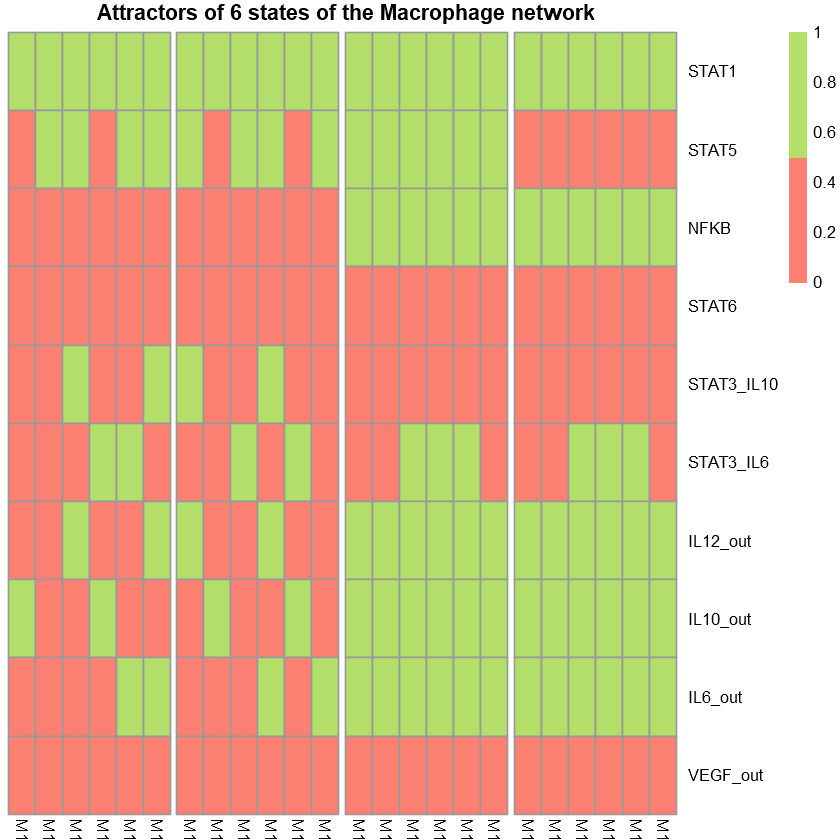

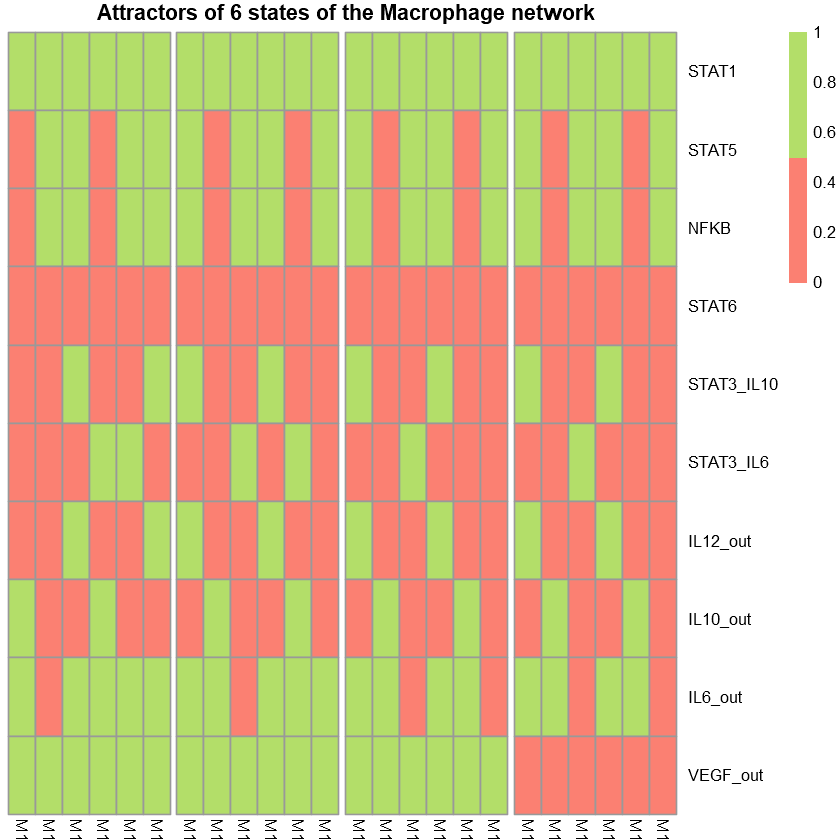

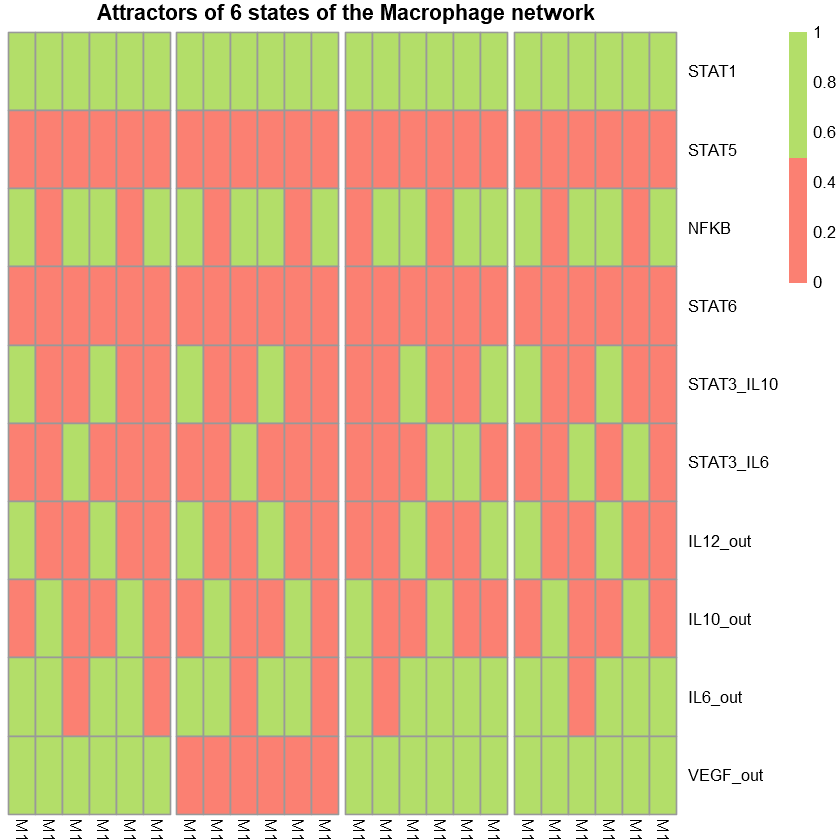

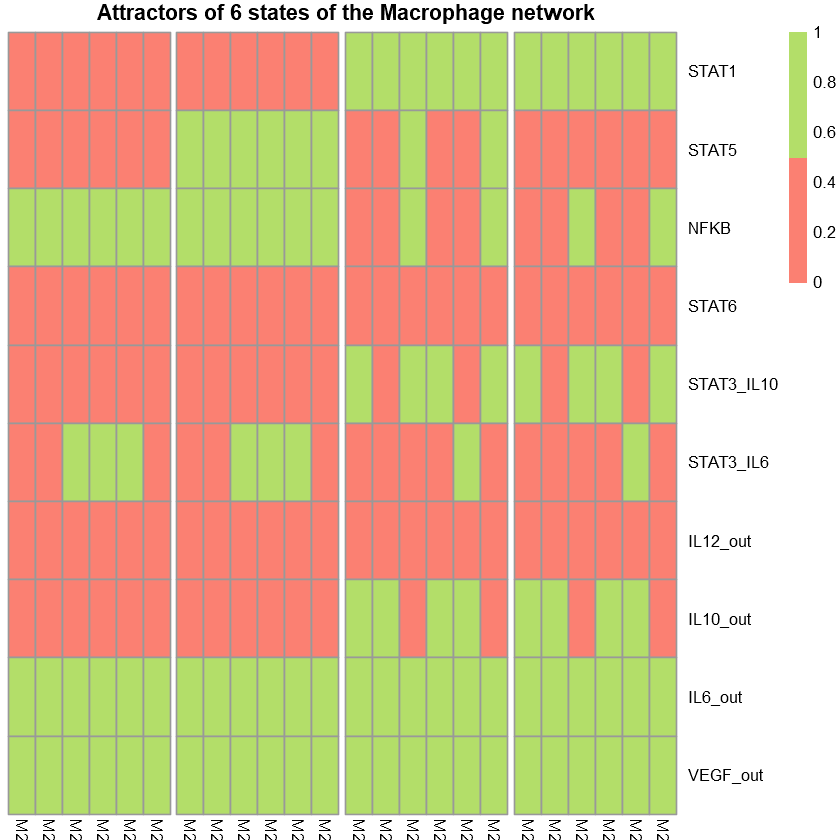

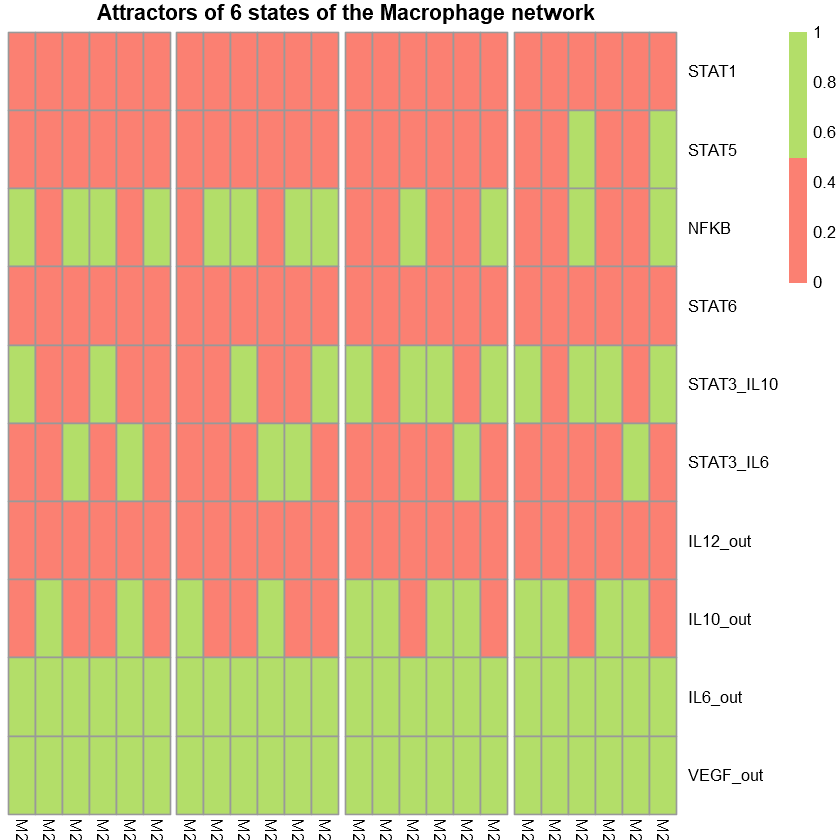

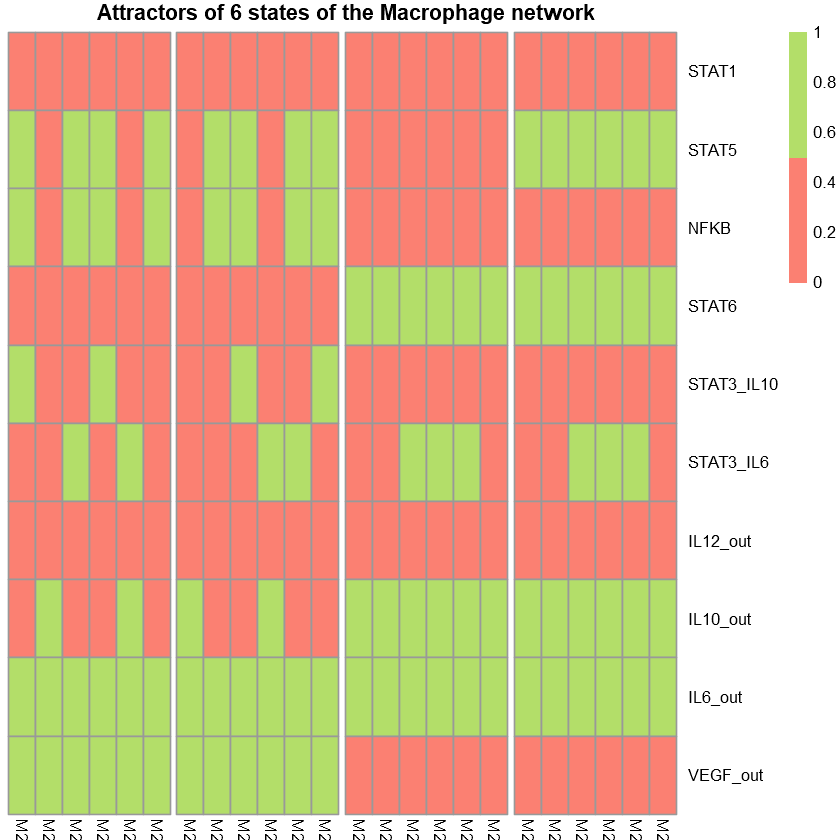

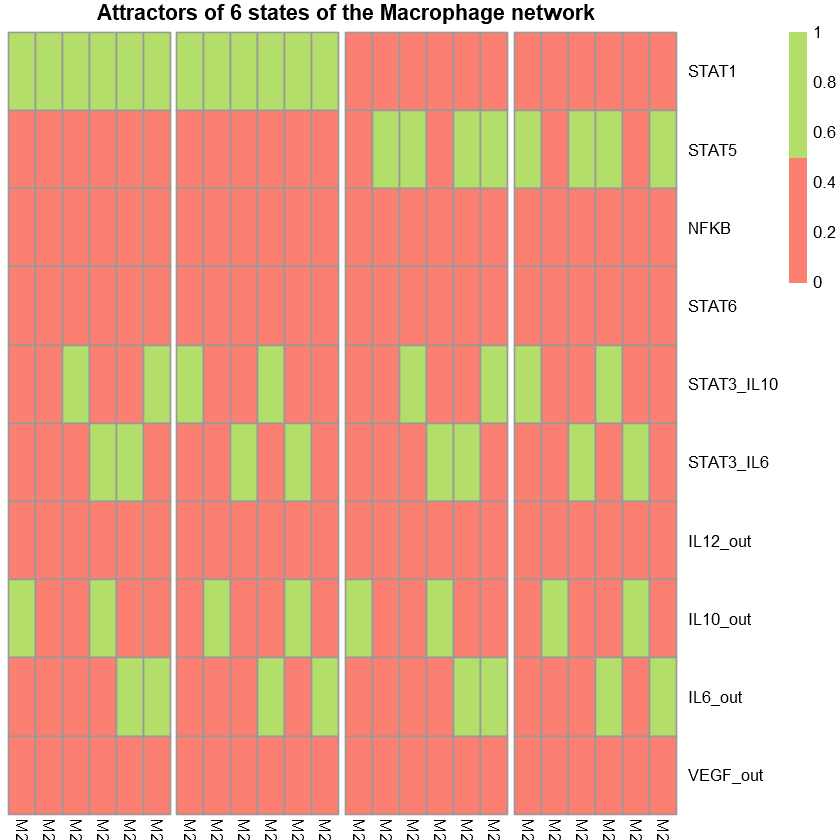

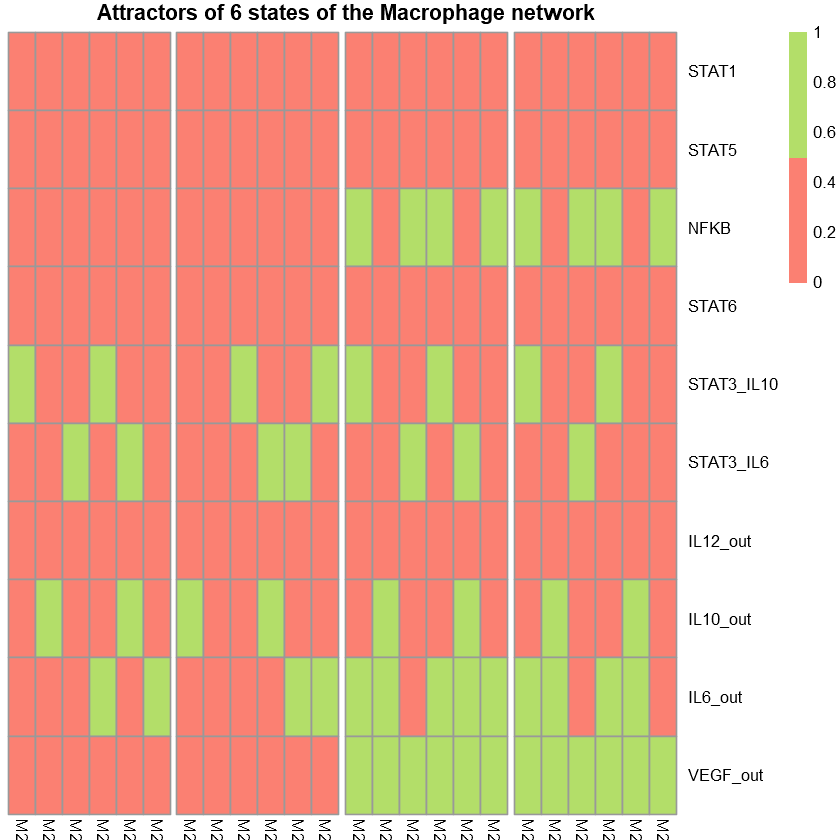

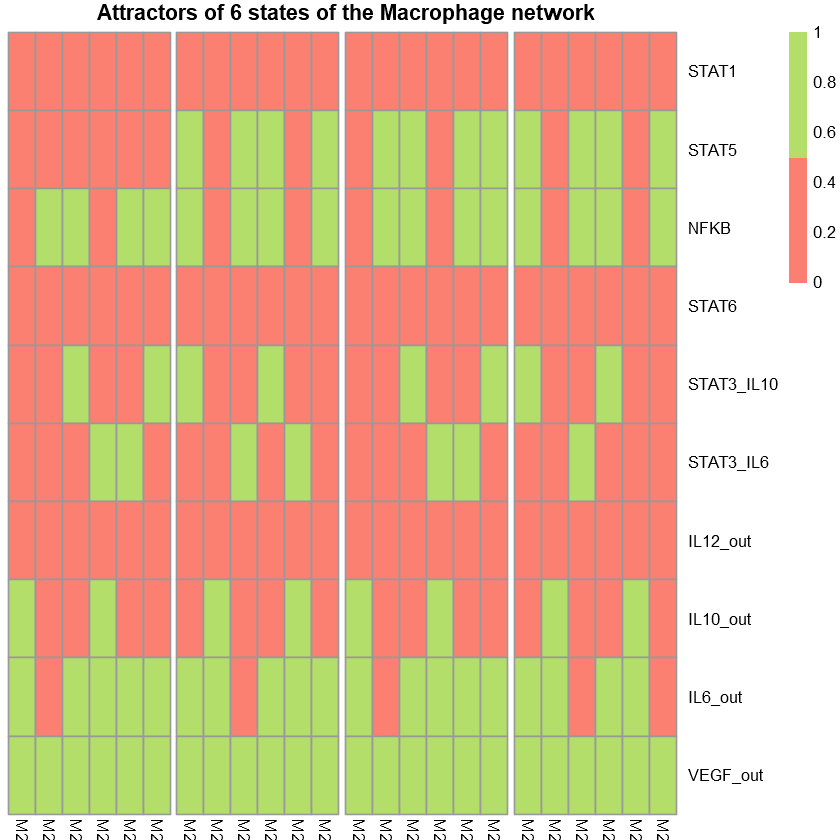

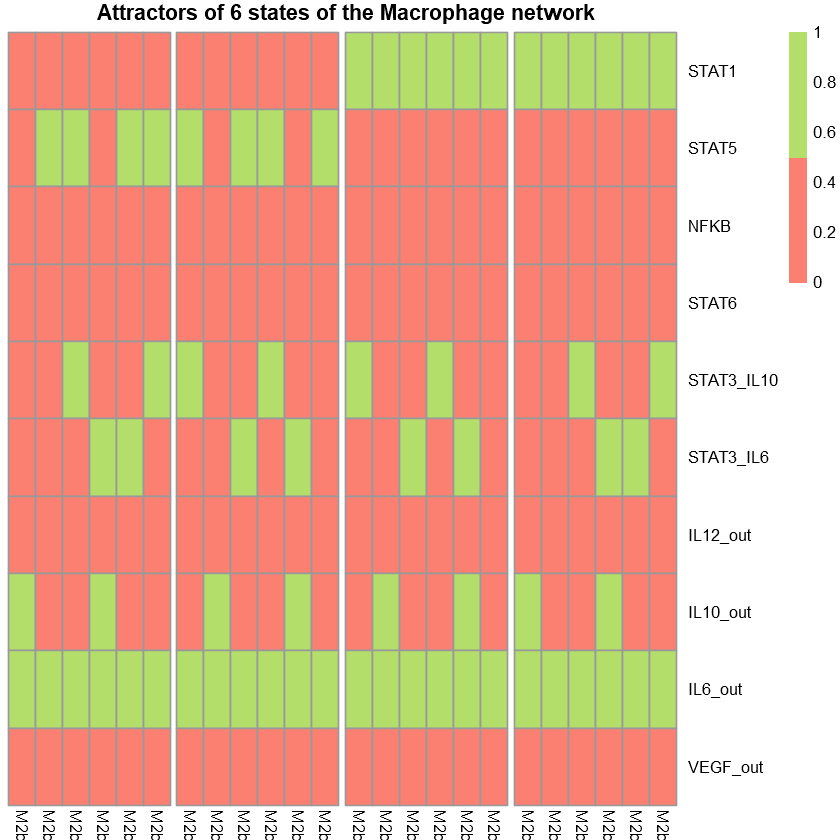

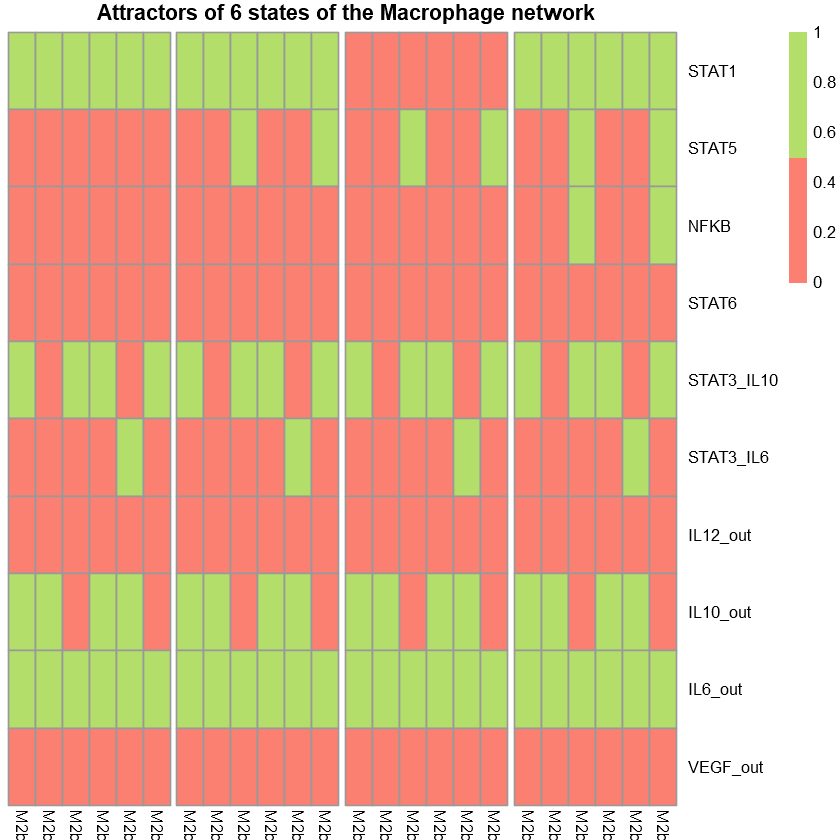

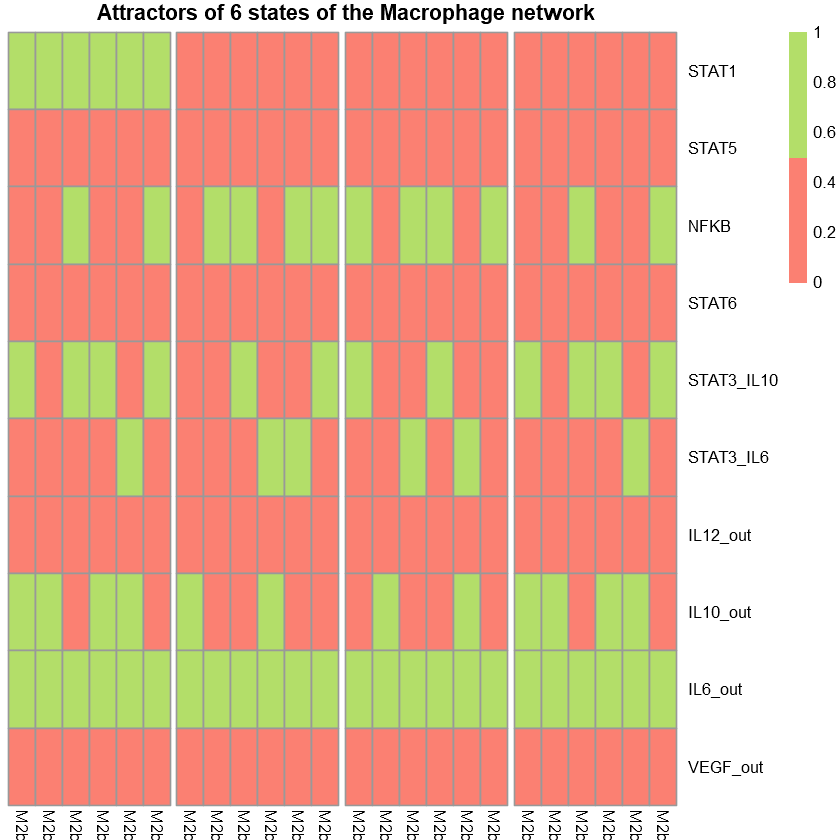

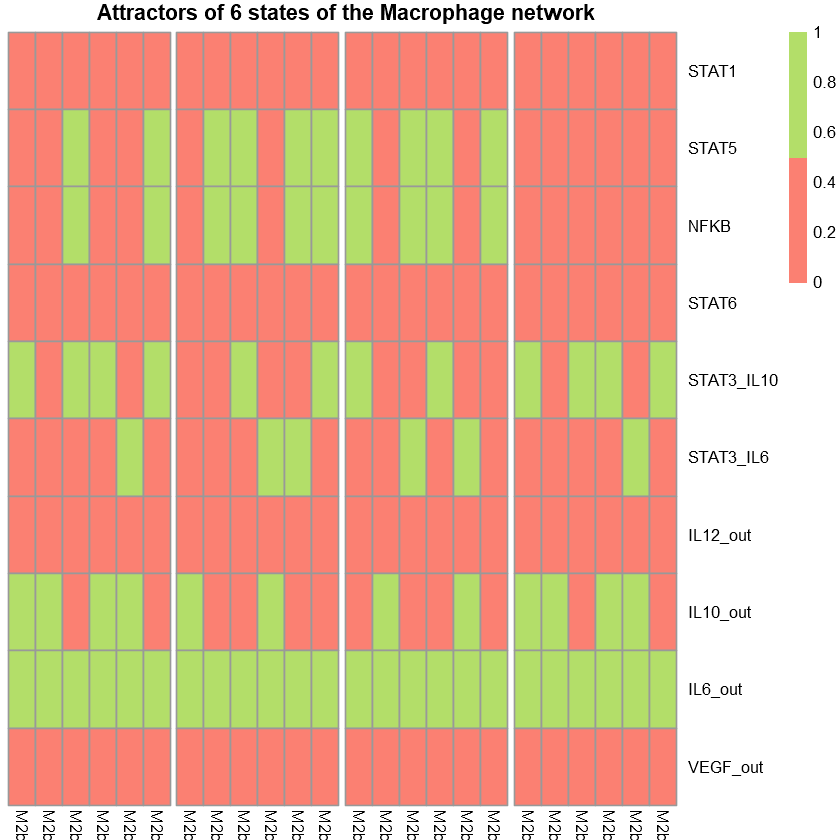

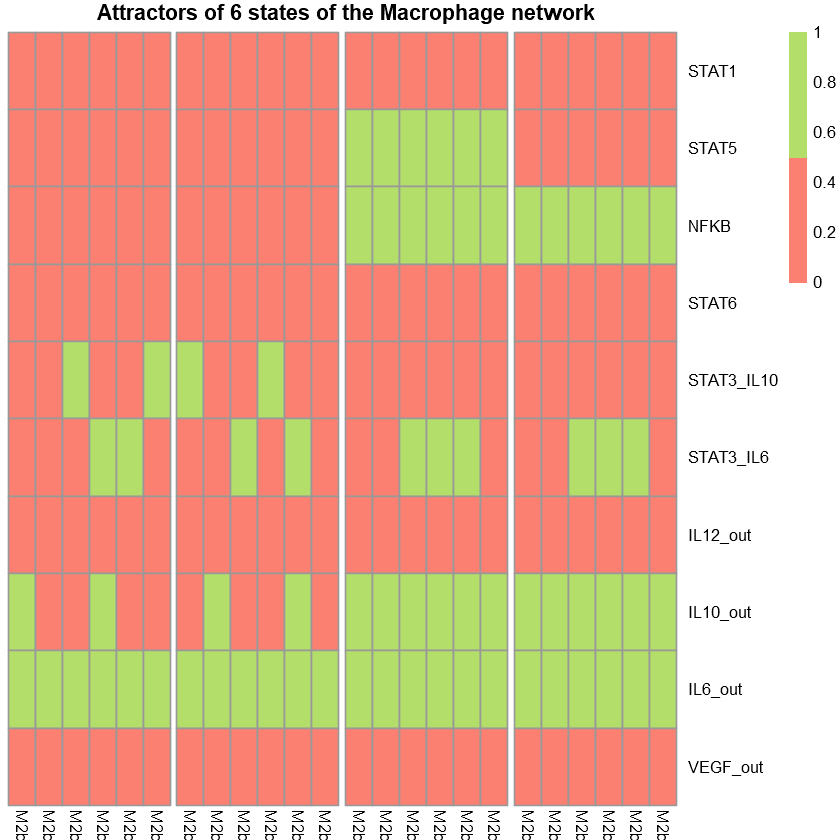

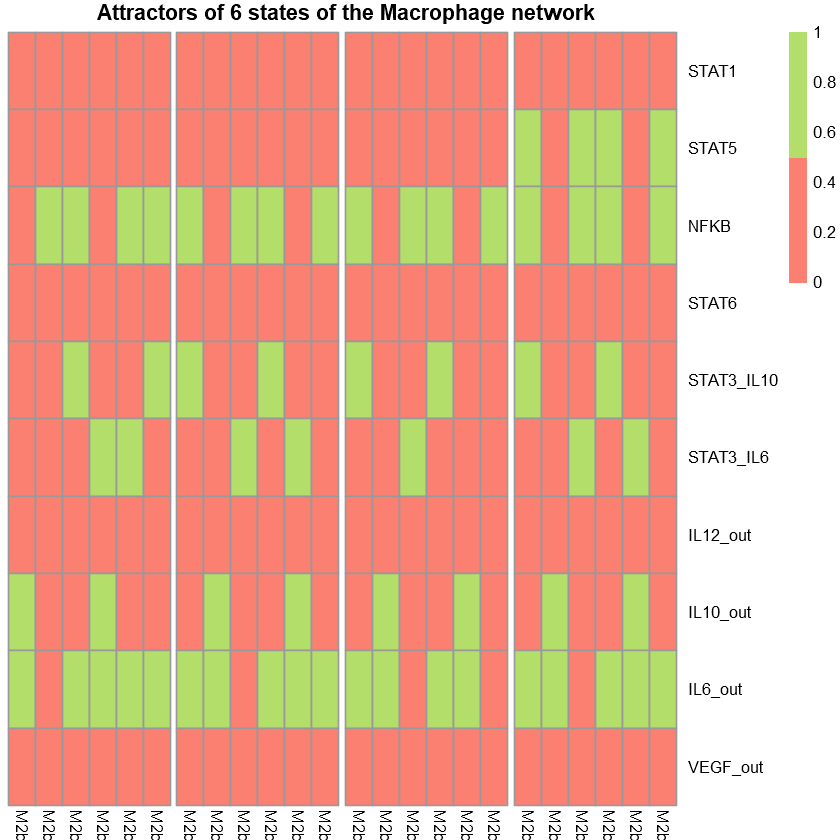

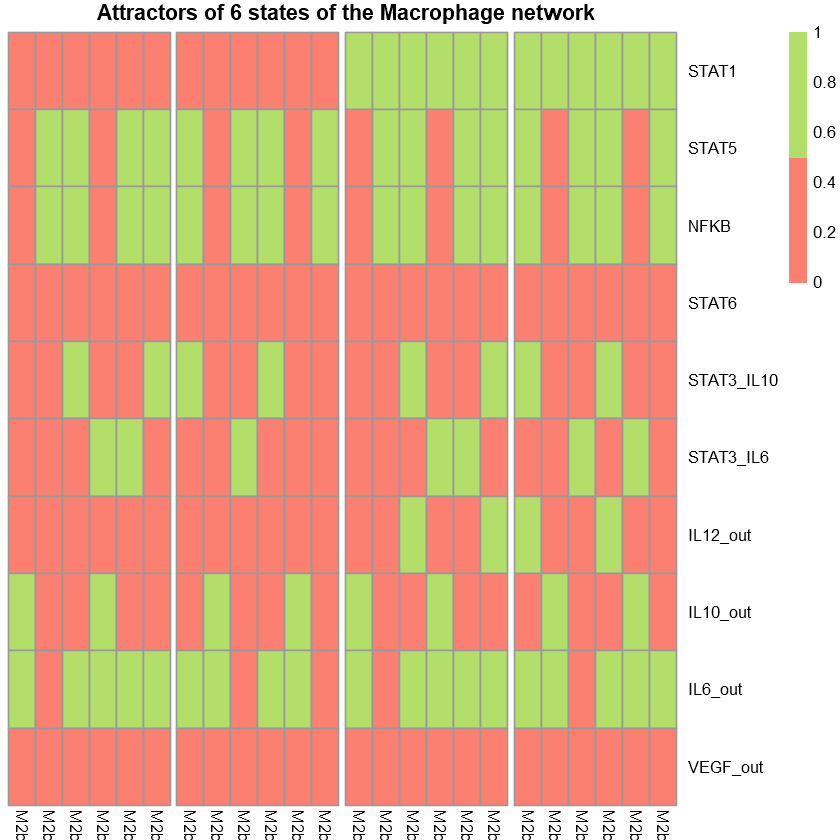

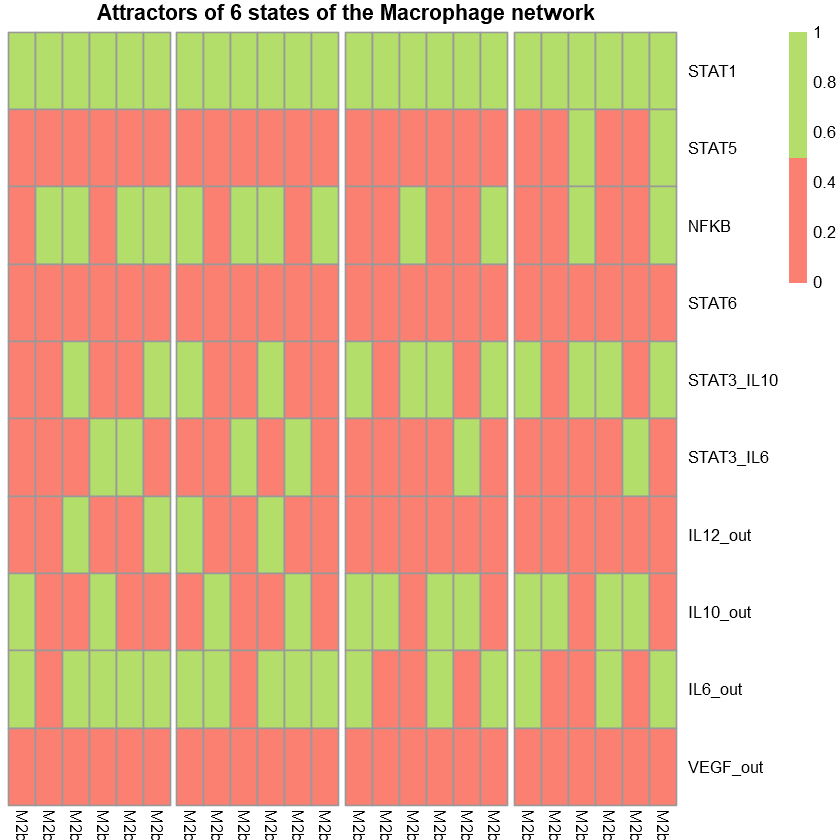

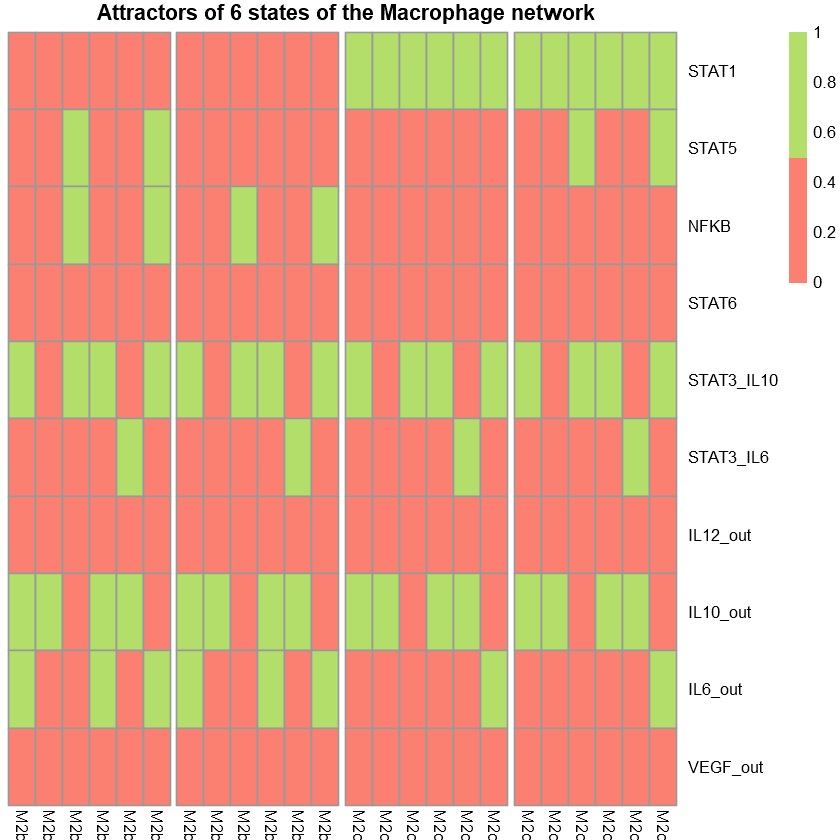

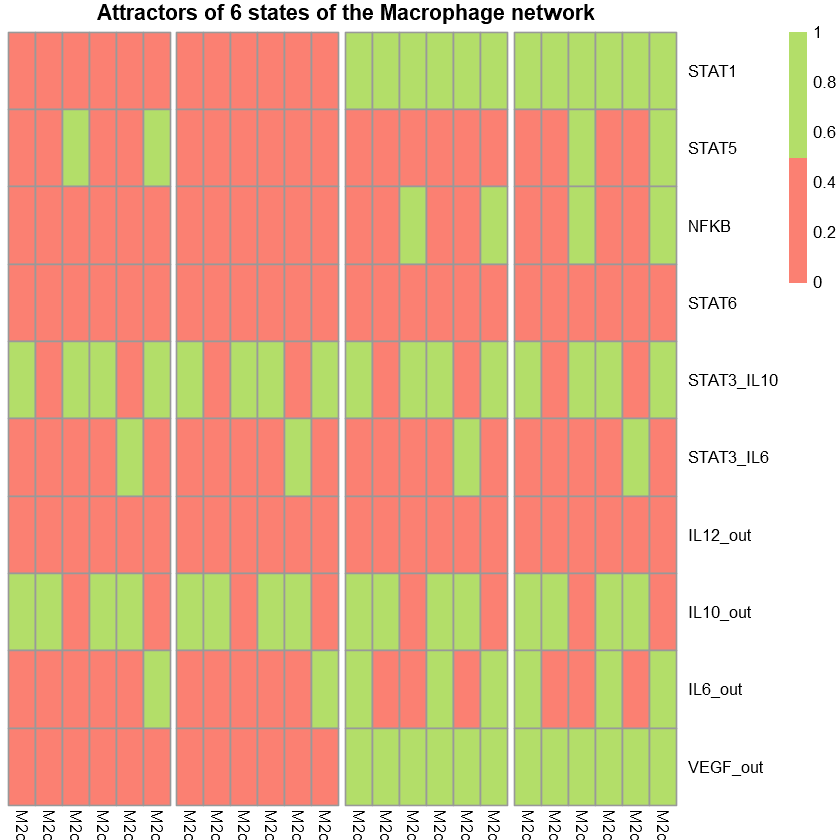

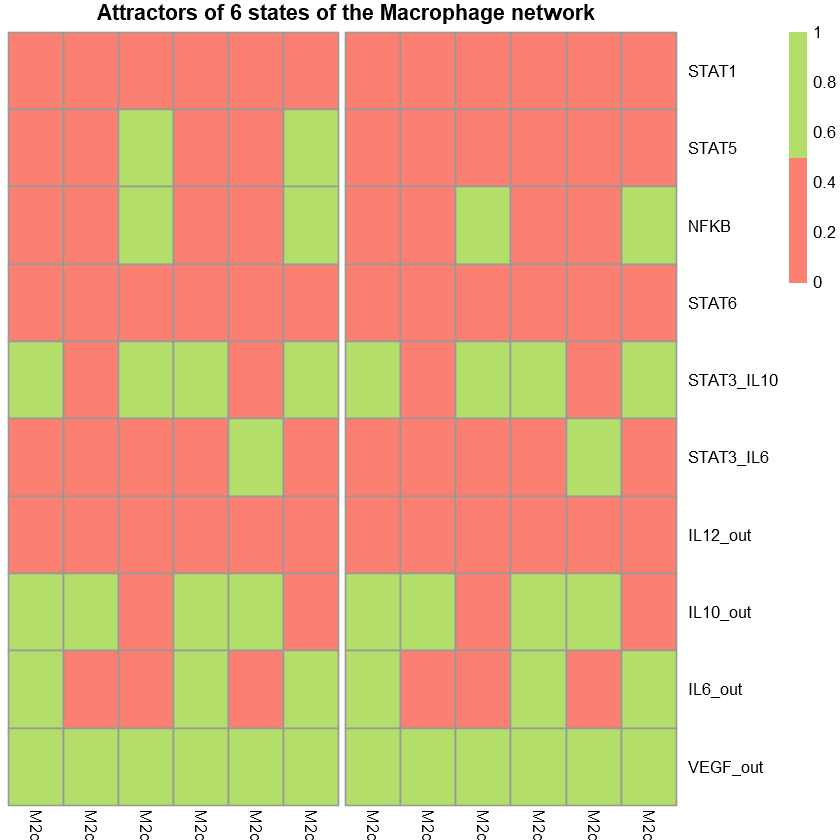

In [6]:
# Plotting the heatmaps of the unique attractors
save.png <- F
save.pdf <- F
file.attr.pdf  <- "PLOT/MP_attractor_heatmaps.pdf"
if (! file.exists(file.attr.pdf)) { pdf(file.attr.pdf); save.pdf <- T}
for(size in cycle.sizes){
      print(size)
      size.attr <- nrow(attr.cycles.list[[size]])
      title <- paste0("Attractors of ", size, " states of the Macrophage network")
      for(block in 1:ceiling(size.attr/24)){
            up.limit <- block*24
            low.limit <- ((block-1)*24)+1
            gap <- 24
            if(all(is.na(attr.cycles.list[[size]][up.limit,]))){
                  up.limit <- (low.limit-1) + nrow(na.omit(attr.cycles.list[[size]][low.limit:up.limit,]))
                  gap <- nrow(na.omit(attr.cycles.list[[size]][low.limit:up.limit,]))
            }
            if (save.png){
            plot.name <- paste0("PLOT/MP_heatmap_size", size, "_block", block, ".png")
            png(plot.name)
            }
            plot.heatmap(attr.table = attr.cycles.list[[size]][low.limit:up.limit,],
                         title = title,
                         gaps = seq(size, gap, size))
            if (save.png) dev.off()
      }
}
if(save.pdf) dev.off()

## Mutants

In [7]:
f.mut.plot <- function(mutants, image.name, save.pdf=FALSE, normalize=T) {
    if (save.pdf) { pdf(image.name) }
    if (normalize) {
        mutants <- mutants/mutants
        color <- c('#bebada')
    } else {
        colfunc <- colorRampPalette(c('#bfd3e6', '#810f7c'))
        color <- colfunc(10)
    }
    
    heatmap(t(as.matrix( mutants )),
            main="Macrophage subsets mutants", 
            xlab="Macrophage subset", ylab="Mutant",
            col=color, cexCol=0.75, cexRow=0.75,
            Colv = NA, Rowv = NA, scale="none",
           )
    if (save.pdf) {dev.off() }
}

In [8]:
mutants.file <- "CSV/MP_attr_mutants.csv"
if (!file.exists(mutants.file)){
    mutants <- perturbNetworkFixedNodes(net, label.rules = lab,
                                    method = "sat.exhaustive")
    mut.labels <- rownames(mutants)
    clean.labels <- list()
    for (i in 1:length(mut.labels)) {
          clean.labels[i] <- simplifyLabel(mut.labels[[i]], replace=replace.labels)
    }
    clean.labels <- unlist(clean.labels)
    mutants <- aggregate(mutants, list(clean.labels), sum)
    rownames(mutants) <- mutants$Group.1
    mutants <- mutants[,-1]
    write.csv(x = mutants, file = mutants.file)
    } else {
    mutants <- read.csv(file = mutants.file, row.names = 1)
    }

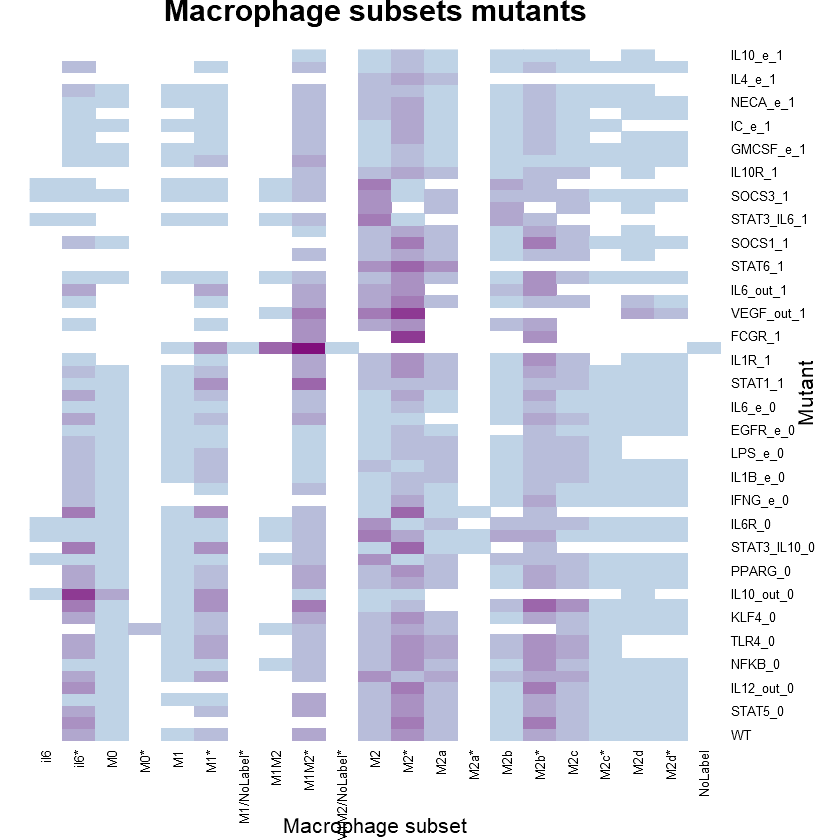

In [9]:
mutants[mutants==0] <- NA
f.mut.plot(mutants, image.name = "PLOT/MP_mutants.pdf", save.pdf=FALSE, normalize=F)

### Mutants attractors

In [10]:
file.mutants.attr.table <- "CSV/MP_attr_mutants_table.csv"
if(!file.exists(file.mutants.attr.table)){
    mutants <- perturbNetworkFixedNodes(net, label.rules = lab,
                                        method = "sat.exhaustive", returnDataFrame = "attrList")
    mutant.tables <- lapply(mutants, function(m.attr){
          m.table <- attractorToDataframe(m.attr, Boolean = T)
          m.l_long <- labelAttractors(m.attr, lab, net$genes)
          m.labels <- data.frame(attractor=NA, label=NA)[numeric(0), ]
          for (a in 1:length(m.l_long)) {
                l <- simplifyLabel(m.l_long[[a]], replace=replace.labels)
                m.labels[nrow(m.labels) + 1,] = c(a,l)
          }
          m.table <- merge(x = m.labels, y = m.table, by = "attractor", all = TRUE)
          est.ind <- (which(str_detect(colnames(m.table), "_e") == T))
          m.table <- m.table[,c(1:3,est.ind ,(4:ncol(m.table))[-(est.ind-3)])]
          m.table <- m.table[order(m.table$label),]
          m.table
    })
    for (n in 1:length(mutant.tables)) {
          mutant.tables[[n]] <- cbind(mutant.tables[[n]],mutant = names(mutant.tables)[n])
    }
    mutant.tables <- rbindlist(mutant.tables)
    fwrite(x = mutant.tables, file = file.mutants.attr.table)
} else {
    mutant.tables <- fread(file = file.mutants.attr.table)
}

In [11]:
mutant.tables[c(10:15,100010:100015,200010:200015),]

attractor,label,state,IFNG_e,GMCSF_e,IL1B_e,IC_e,LPS_e,NECA_e,EGFR_e,...,STAT6,IL10_out,SOCS1,PPARG,STAT3_IL6,STAT3_IL10,SOCS3,IL6R,IL10R,mutant
1109,il6*,2,0,1,0,1,0,0,1,...,0,0,0,0,0,0,1,1,0,WT
1110,il6*,1,0,1,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,WT
1110,il6*,2,0,1,0,1,0,0,1,...,0,0,0,0,0,0,1,1,0,WT
1111,il6*,1,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,WT
1111,il6*,2,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,WT
1112,il6*,1,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,WT
2573,M1M2*,2,1,1,1,1,1,0,1,...,0,1,0,0,0,0,0,1,1,STAT6_0
2573,M1M2*,3,1,1,1,1,1,0,1,...,0,1,0,0,1,0,0,1,1,STAT6_0
2573,M1M2*,4,1,1,1,1,1,0,1,...,0,1,0,0,1,0,1,1,1,STAT6_0
2573,M1M2*,5,1,1,1,1,1,0,1,...,0,1,0,0,1,0,1,0,1,STAT6_0


## Enviroments

In [12]:
file.env <- "CSV/MP_enviroments.csv"
if(! file.exists(file.env)) {
    estimulus <- net$genes[str_detect(net$genes, "_e")]
    set.env <- function(genes, estimulus){
        ind <- match(genes, estimulus)
        env <- rep(0, length(estimulus))
        env[ind] <- 1
        names(env) <- estimulus
        env
    }
    pro_M1 <- set.env(c("IFNG_e", "LPS_e", "GMCSF_e"), estimulus)
    pro_M2a <- set.env(c("IL4_e"), estimulus)
    pro_M2b <- set.env(c("LPS_e","IC_e", "IL1B_e"), estimulus)
    pro_M2c <- set.env(c("IL10_e"), estimulus)
    pro_M2d <- set.env(c("LPS_e", "IL6_e", "NECA_e"), estimulus)
    env <- t(data.frame(pro_M1, pro_M2a, pro_M2b, pro_M2c, pro_M2d))
    write.csv(x = env, file = file.env)
} else {
     env <- read.csv(file = file.env, row.names = 1)
}
env

,IFNG_e,GMCSF_e,IL1B_e,IC_e,LPS_e,NECA_e,EGFR_e,IL4_e,IL6_e,IL10_e
pro_M1,1,1,0,0,1,0,0,0,0,0
pro_M2a,0,0,0,0,0,0,0,1,0,0
pro_M2b,0,0,1,1,1,0,0,0,0,0
pro_M2c,0,0,0,0,0,0,0,0,0,1
pro_M2d,0,0,0,0,1,1,0,0,1,0


In [13]:
file.env.analysis <- "CSV/MP_enviroments_analysis.csv"
if (! file.exists(file.env.analysis)) {
    envMacrophages <- list(label = rownames(env),
                       nodes = rep( list(colnames(env)), times=nrow(env) ),
                       values = lapply(rownames(env), function(row){env[row,]}))
    env.attr <- perturbNetworkFixedNodes(net, label.rules = lab,
                                     genes = envMacrophages$nodes,
                                     values = envMacrophages$values,
                                     names = envMacrophages$label,
                                     method = "sat.exhaustive")
    env.labels <- rownames(env.attr)
    clean.labels <- list()
    for (i in 1:length(env.labels)) {
        clean.labels[i] <- simplifyLabel(env.labels[[i]], replace=replace.labels)
    }
    clean.labels <- unlist(clean.labels)
    env.attr <- aggregate(env.attr, list(clean.labels), sum)
    rownames(env.attr) <- env.attr$Group.1
    env.attr <- env.attr[,-1]
    write.csv(x = env.attr, file = file.env.analysis)
    } else {
    env.attr <- read.csv(file.env.analysis, row.names = 1)
}
env.attr

,pro_M1,pro_M2a,pro_M2b,pro_M2c,pro_M2d
M1*,2,0,0,0,0
M1M2*,1,0,0,0,0
M2*,0,0,0,0,4
M2a,0,1,0,0,0
M2b*,1,0,2,0,0
M2c,1,0,0,1,0
M2d,0,0,0,0,1
M2d*,0,0,0,0,1


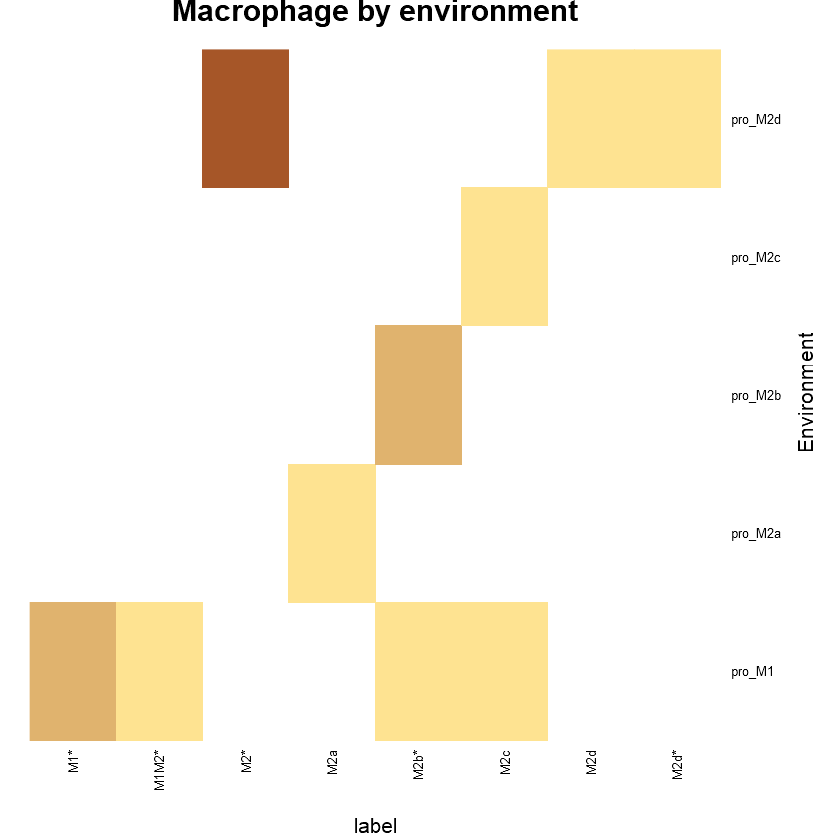

In [14]:
env.attr <- read.csv(file.env.analysis, row.names = 1)
file.env.attr.pdf <- "PLOT/MP_env_attr.pdf"
env.attr[env.attr == 0] <- NA
normalize = F
if (normalize) {
   env.attr <- env.attr/env.attr
   color = '#a65628'
} else { 
   colfunc <- colorRampPalette(c('#fee391', '#a65628'))
   color <- colfunc(10)
}
save.pdf <- F
if (!file.exists(file.env.attr.pdf)) { pdf(file.env.attr.pdf); save.pdf <- T }
heatmap(t(as.matrix( subset(env.attr ))),
        main="Macrophage by environment", 
        xlab="label", ylab="Environment",
        col=color, cexCol=0.75, cexRow=0.75,
        Colv = NA, Rowv = NA, scale="none",
)
if(save.pdf) dev.off()

### Enviroment attractors

In [15]:
file.env.attr <- "CSV/MP_env_attr.csv"
if(!file.exists(file.env.attr)){
    envMacrophages <- list(label = rownames(env),
                           nodes = rep( list(colnames(env)), times=nrow(env) ),
                           values = lapply(rownames(env), function(row){env[row,]}))
    enviroments <- perturbNetworkFixedNodes(net, label.rules = lab,
                                         genes = envMacrophages$nodes,
                                         values = envMacrophages$values,
                                         names = envMacrophages$label,
                                         method = "sat.exhaustive",
                                         returnDataFrame = "attrList")
    env.tables <- lapply(enviroments, function(e.attr){
          e.table <- attractorToDataframe(e.attr, Boolean = T)
          e.l_long <- labelAttractors(e.attr, lab, net$genes)
          e.labels <- data.frame(attractor=NA, label=NA)[numeric(0), ]
          for (a in 1:length(e.l_long)) {
                l <- simplifyLabel(e.l_long[[a]], replace=replace.labels)
                e.labels[nrow(e.labels) + 1,] = c(a,l)
          }
          e.table <- merge(x = e.labels, y = e.table, by = "attractor", all = TRUE)
          est.ind <- (which(str_detect(colnames(e.table), "_e") == T))
          e.table <- e.table[,c(1:3,est.ind ,(4:ncol(e.table))[-(est.ind-3)])]
          e.table <- e.table[order(e.table$label),]
          e.table
    })
    for (n in 1:length(env.tables)) {
          env.tables[[n]] <- cbind(env.tables[[n]],enviroment = names(env.tables)[n])
    }
    env.tables <- rbindlist(env.tables)
    write.csv(x = env.tables, file = file.env.attr)
    } else {
    env.tables <- read.csv(file = file.env.attr, row.names = 1)
}
env.tables[c(17:21,27:30),]

,attractor,label,state,IFNG_e,GMCSF_e,IL1B_e,IC_e,LPS_e,NECA_e,EGFR_e,...,STAT6,IL10_out,SOCS1,PPARG,STAT3_IL6,STAT3_IL10,SOCS3,IL6R,IL10R,enviroment
17,3,M2b*,3,1,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,pro_M1
18,1,M2c,1,1,1,0,0,1,0,0,...,0,1,0,0,0,1,1,0,1,pro_M1
19,1,M2a,1,0,0,0,0,0,0,0,...,1,1,1,1,0,1,1,0,1,pro_M2a
20,1,M2b*,1,0,0,1,1,1,0,0,...,0,1,0,0,1,0,0,0,1,pro_M2b
21,1,M2b*,2,0,0,1,1,1,0,0,...,0,1,0,0,0,0,1,1,1,pro_M2b
27,2,M2b*,6,0,0,1,1,1,0,0,...,0,1,0,0,0,0,1,0,1,pro_M2b
28,1,M2c,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,1,pro_M2c
29,2,M2*,1,0,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,pro_M2d
30,2,M2*,2,0,0,0,0,1,1,0,...,0,0,0,0,0,0,1,1,0,pro_M2d


## Macrophage Plasticity

In [16]:
file.cfm.raw <- "CSV/MP_cfm_raw.csv"
file.cfm.label <- "CSV/MP_cfm_label.csv"
if(!file.exists(file.cfm.raw)){    
    cfm <- cellFateMap(net, method="sat.exhaustive", maxAttractorLength=6) 
    cfm <- as.data.frame(apply(cfm,2,as.character))
    write.csv(x = cfm, file = file.cfm.raw, row.names = F)
    } else { cfm  <- read.csv(file = file.cfm.raw)}
if(!file.exists(file.cfm.label)){
    cfm <- cfm[  order( cfm[,1], cfm[,2], cfm[,3], cfm[,4] ),]
    cfm.label <- merge(x=cfm, y=labels[c('state','label')], by.x='initial', by.y="state", all.x = TRUE)
    colnames(cfm.label)[5] <- 'initial_label'
    cfm.label$final.split <- sapply(cfm.label$final,function(s) strsplit(s,'/')[[1]][1])
    cfm.label <- merge(x=cfm.label, y=labels[c('state','label')], by.x='final.split', by.y="state", all.x = TRUE)
    colnames(cfm.label)[7] <- 'final_label'
    cfm.label <- cfm.label[,-1]
    write.csv(cfm.label, file.cfm.label, row.names = F)
    } else { 
    cfm.label <- read.csv(file.cfm.label)
    cfm.label$initial_label <- as.factor(cfm.label$initial_label)
    cfm.label$final_label <- as.factor(cfm.label$final_label)
    cfm.label$genes <- as.factor(cfm.label$genes)
    }

In [17]:
head(cfm.label)

initial,final,genes,values,initial_label,final_label
0,0,EGFR_e,1,M0,M0
0,0,GMCSF_e,1,M0,M0
0,0,IC_e,1,M0,M0
0,0,IFNG_e,1,M0,M0
0,0,IL12_out,1,M0,M0
0,0,IL6_e,1,M0,M0


## Transitions by node

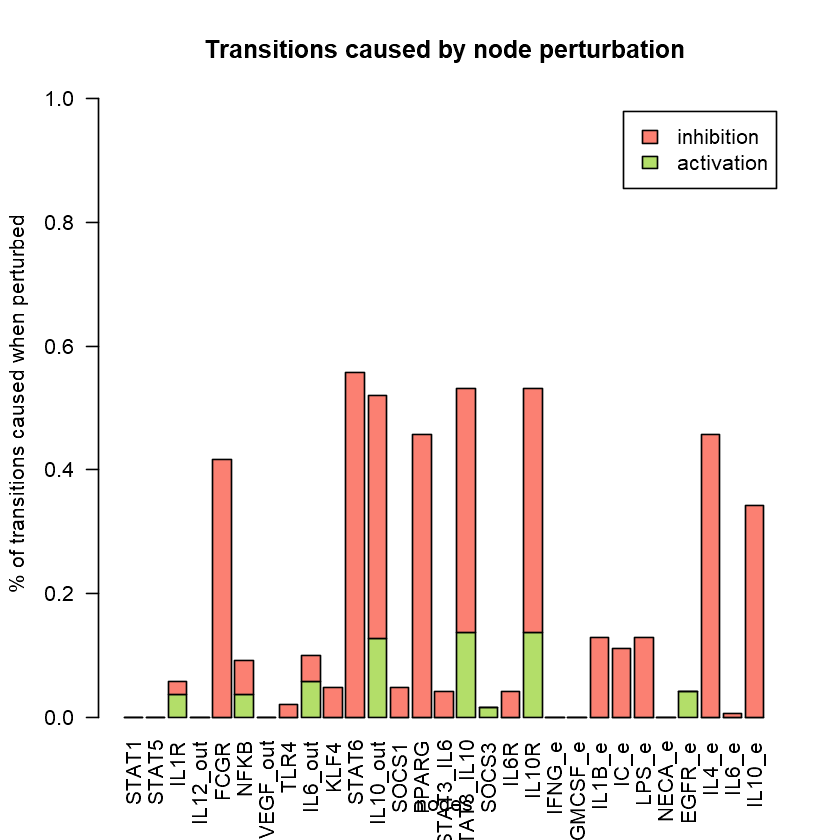

In [18]:
file.transition.pdf <- "PLOT/MP_transitionnode.pdf"
cfm.diff <- cfm.label[cfm.label$initial_label!=cfm.label$final_label,]
node.transitions <- merge( summary(cfm.diff[cfm.diff$values==0,'genes']), 
                           summary(cfm.diff[cfm.diff$values==1,'genes']),
                           by=0, all=TRUE)
rownames(node.transitions) <- node.transitions$Row.names
node.transitions <- subset(node.transitions, select = -Row.names )
colnames(node.transitions) <- c('activation','inhibition')
node.transitions <- node.transitions[net$genes,]
node.transitions <- node.transitions/summary(cfm.label$genes)

save.pdf <- F
if (!file.exists(file.transition.pdf)) { pdf(file.transition.pdf); save.pdf <- T } 
barplot(t(as.matrix( node.transitions )),
        main="Transitions caused by node perturbation", 
        xlab='nodes', ylab='% of transitions caused when perturbed',
        col=c('#b3de69','#fb8072'), ylim=c(0,1), las=2, legend=T,
)
if(save.pdf) dev.off()
#node.transitions

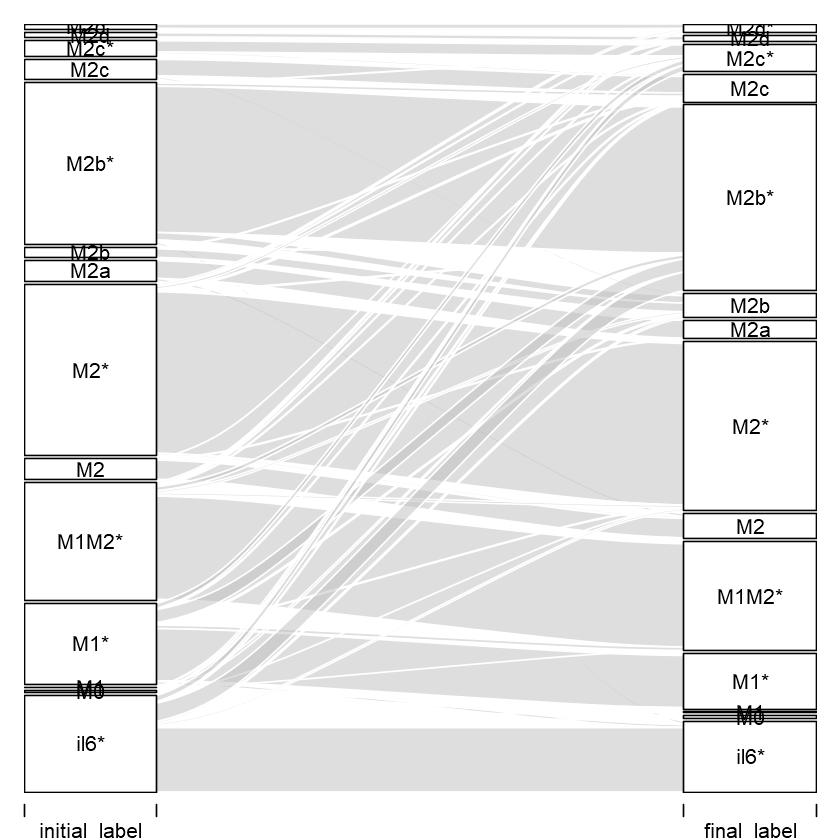

In [19]:
file.alluvial.pdf <- "PLOT/MP_alluvial.pdf"
save.pdf <- F
cfm.label <- read.csv("CSV/MP_cfm_label.csv")
if(!file.exists(file.alluvial.pdf)) { pdf(file.alluvial.pdf); save.pdf <- T }
cfm2d <- cfm.label %>% group_by(initial_label, final_label) %>%
      summarize(freq = n())
alluvial(cfm2d[,1:2], freq=cfm2d$freq)
if(save.pdf) dev.off()
